# **Introduction**

Wind power is a key source of renewable energy, offering a sustainable alternative to fossil fuels with minimal environmental impact. It is harnessed using wind turbines in both onshore and offshore wind farms, which generate electricity for power grids or isolated locations.

**Objective**
The primary objective of this project is to forecast wind power generation in Germany for December 2019 using historical data. This prediction will help in understanding energy trends and optimizing renewable energy management strategies.

**Data Description**
The dataset consists of daily measurements of three key variables recorded from 2017 to 2019:

*Wind Generation Actual:* The actual daily wind power generation.

*Wind Capacity:* The installed wind power generation capacity.

*Temperature:* The daily temperature.

*UTC Timestamp:* The date and time corresponding to the measurements, recorded daily.

In [1]:
DrivePath = '/content/drive/My Drive/Colab Notebooks'

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm

from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from scipy.stats import pearsonr

!pip install statsforecast
from statsforecast.models import SeasonalNaive

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.style.use('seaborn-v0_8')


# Load Data

In [30]:
#load data while by setting up the index column while changing to data format
wind_power_df = pd.read_csv(DrivePath +'/Data/WindEnergy.csv', sep=',', parse_dates=['utc_timestamp'], index_col='utc_timestamp')

In [ ]:
wind_power_df.head(5)

wind_generation_actual  wind_capacity  temperature
utc_timestamp                                                                
2017-01-01 00:00:00+00:00                291760.0      37149.130       -2.117
2017-01-02 00:00:00+00:00                295097.0      37152.125       -1.154
2017-01-03 00:00:00+00:00                666170.0      37155.208       -0.239
2017-01-04 00:00:00+00:00                686581.0      37160.125        0.620
2017-01-05 00:00:00+00:00                261759.0      37163.542       -3.908

In [ ]:
wind_power_df.index

DatetimeIndex(['2017-01-01 00:00:00+00:00', '2017-01-02 00:00:00+00:00',
               '2017-01-03 00:00:00+00:00', '2017-01-04 00:00:00+00:00',
               '2017-01-05 00:00:00+00:00', '2017-01-06 00:00:00+00:00',
               '2017-01-07 00:00:00+00:00', '2017-01-08 00:00:00+00:00',
               '2017-01-09 00:00:00+00:00', '2017-01-10 00:00:00+00:00',
               ...
               '2019-12-21 00:00:00+00:00', '2019-12-22 00:00:00+00:00',
               '2019-12-23 00:00:00+00:00', '2019-12-24 00:00:00+00:00',
               '2019-12-25 00:00:00+00:00', '2019-12-26 00:00:00+00:00',
               '2019-12-27 00:00:00+00:00', '2019-12-28 00:00:00+00:00',
               '2019-12-29 00:00:00+00:00', '2019-12-30 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='utc_timestamp', length=1094, freq=None)

In [ ]:
#now the date column is DATE type

## Preprocessing

In [4]:
#remove timpestamp component and keep only th date
wind_power_df.index = wind_power_df.index.date

In [ ]:
wind_power_df.head(5)

wind_generation_actual  wind_capacity  temperature
2017-01-01                291760.0      37149.130       -2.117
2017-01-02                295097.0      37152.125       -1.154
2017-01-03                666170.0      37155.208       -0.239
2017-01-04                686581.0      37160.125        0.620
2017-01-05                261759.0      37163.542       -3.908

In [5]:
#add the name to index column
wind_power_df.index.name = 'date'

In [ ]:
wind_power_df.head(5)

wind_generation_actual  wind_capacity  temperature
date                                                          
2017-01-01                291760.0      37149.130       -2.117
2017-01-02                295097.0      37152.125       -1.154
2017-01-03                666170.0      37155.208       -0.239
2017-01-04                686581.0      37160.125        0.620
2017-01-05                261759.0      37163.542       -3.908

In [ ]:
wind_power_df.shape

(1094, 3)

In [ ]:
#check for data types
wind_power_df.dtypes

wind_generation_actual    float64
wind_capacity             float64
temperature               float64
dtype: object

In [ ]:
wind_power_df.index

Index([2017-01-01, 2017-01-02, 2017-01-03, 2017-01-04, 2017-01-05, 2017-01-06,
       2017-01-07, 2017-01-08, 2017-01-09, 2017-01-10,
       ...
       2019-12-21, 2019-12-22, 2019-12-23, 2019-12-24, 2019-12-25, 2019-12-26,
       2019-12-27, 2019-12-28, 2019-12-29, 2019-12-30],
      dtype='object', name='date', length=1094)

In [6]:
#since eariler manually removed the timestamp compenent, datatype of index had changed to object, so change from object type to datetime
wind_power_df.index = pd.to_datetime(wind_power_df.index)

In [ ]:
wind_power_df.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2019-12-21', '2019-12-22', '2019-12-23', '2019-12-24',
               '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-28',
               '2019-12-29', '2019-12-30'],
              dtype='datetime64[ns]', name='date', length=1094, freq=None)

In [7]:
#set frequecny to daily
wind_power_df = wind_power_df.asfreq('D')

In [ ]:
wind_power_df.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2019-12-21', '2019-12-22', '2019-12-23', '2019-12-24',
               '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-28',
               '2019-12-29', '2019-12-30'],
              dtype='datetime64[ns]', name='date', length=1094, freq='D')

In [ ]:
#check for null values
wind_power_df.isnull().sum()

wind_generation_actual    0
wind_capacity             0
temperature               0
dtype: int64

In [ ]:
#No missing values in the dataset

## Exploratory analysis

In [ ]:
#confirm no null values
wind_power_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2017-01-01 to 2019-12-30
Freq: D
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   wind_generation_actual  1094 non-null   float64
 1   wind_capacity           1094 non-null   float64
 2   temperature             1094 non-null   float64
dtypes: float64(3)
memory usage: 34.2 KB


In [ ]:
wind_power_df.describe()

wind_generation_actual  wind_capacity  temperature
count             1094.000000    1094.000000  1094.000000
mean            305819.767824   45066.022789    10.050167
std             205728.857915    4315.838061     7.739158
min              16482.000000   37149.130000    -9.363000
25%             148552.750000   41447.937500     3.577250
50%             254332.500000   46073.000000    10.046500
75%             412570.500000   49203.000000    16.566000
max             998899.000000   50452.000000    28.241000

## **Remarks**

*   The wind_generation_actual column has a wide range of values (from 16,482 to 998,899) with a high standard deviation, suggesting considerable variation.

*   The wind_capacity column also shows a range from 37,149.13 to 50,452, with moderate variability.

*   The temperature column shows a lower range of variation, with temperatures ranging from -9.36°C to 28.24°C.



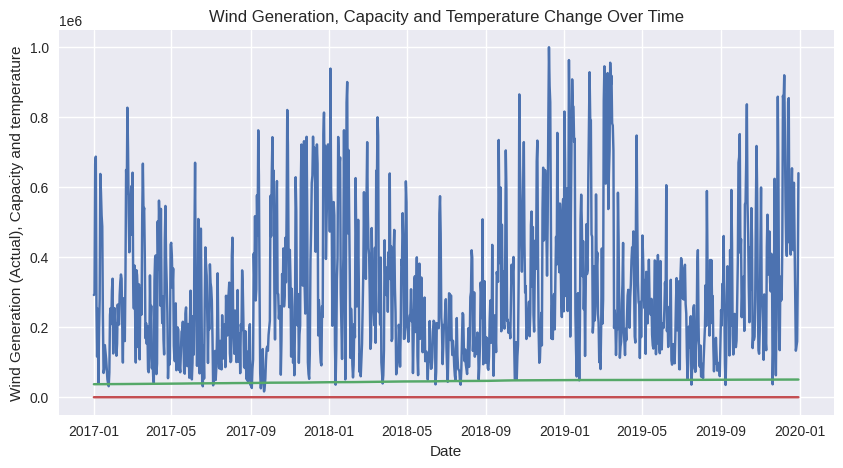

In [ ]:
#visualize change of all variables over time
fig = plt.figure(figsize=(10,5))
plt.plot(wind_power_df)
plt.xlabel('Date')
plt.ylabel('Wind Generation (Actual), Capacity and temperature')
plt.title('Wind Generation, Capacity and Temperature Change Over Time')
plt.show()

### ***Observation:*** Since value ranges are high, autmatically y axis in scientific notation, so does not clear the patterns, specially temperature and capacity change

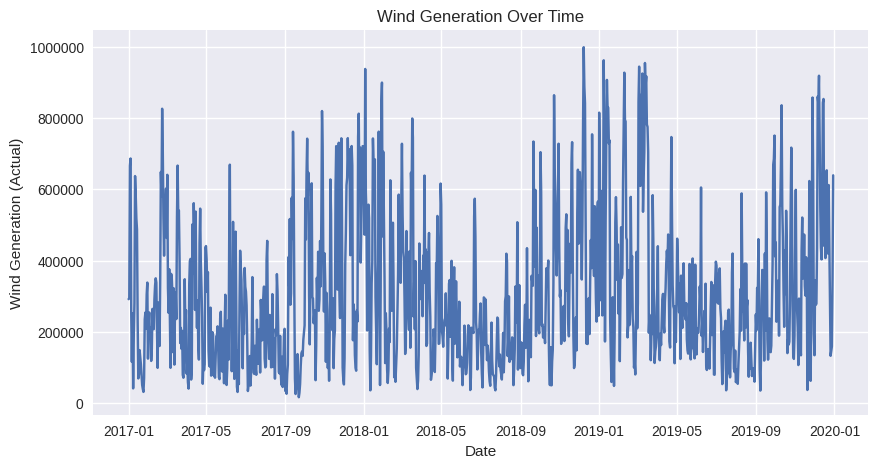

In [ ]:
#visualize actual wind genegration over time with y axis with actual values
fig = plt.figure(figsize=(10,5))
plt.plot(wind_power_df.index, wind_power_df['wind_generation_actual'])
plt.xlabel('Date')
plt.ylabel('Wind Generation (Actual)')
plt.title('Wind Generation Over Time')
plt.ticklabel_format(style='plain', axis='y') # y-axis to avoid scientific notation
plt.show()

### ***Observation:*** there is slightly increasing trend and showa a seasonality begining of the year starts decreasing were in the middle months decreases to a law point and starts to increase till the end of the year

<ipython-input-24-ff0ac1936248>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wind_power_df_resampled = wind_power_df['wind_generation_actual'].resample('M').mean()


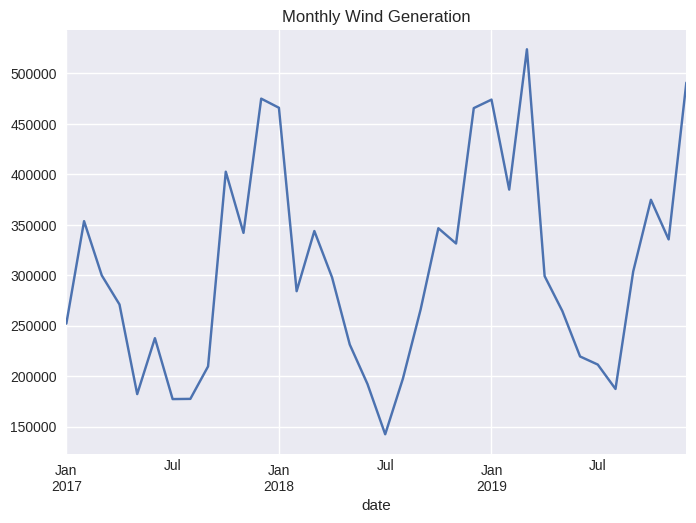

In [ ]:
#so resample by month to check furthur whether there is seasonality
wind_power_df_resampled = wind_power_df['wind_generation_actual'].resample('M').mean()
wind_power_df_resampled.plot(title="Monthly Wind Generation")
plt.show()

## ***Observation:***


*  It appears to drop significantly at certain points (e.g., mid-2017, mid-2018,
mid-2019).
*   Peaks also recur, often toward the start or end of each year.
*   The generation fluctuates significantly, with some months showing much higher generation than others. This may be influenced by external factors like weather conditions.


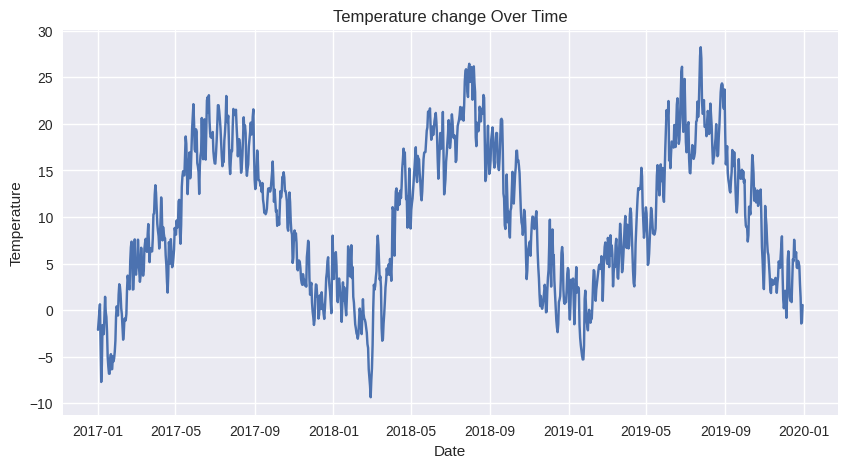

In [ ]:
#visualize temperature over time
fig = plt.figure(figsize=(10,5))
plt.plot(wind_power_df.index, wind_power_df['temperature'])
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature change Over Time')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

### ***Observation:*** It is noticable that the chaging pattern of actual wind generation and temperature shows a connection pattern which is inverse. For an instance the wind generation is high in the begining where temperature is law and when the middle of the year temperature decreases where wind generation increases.

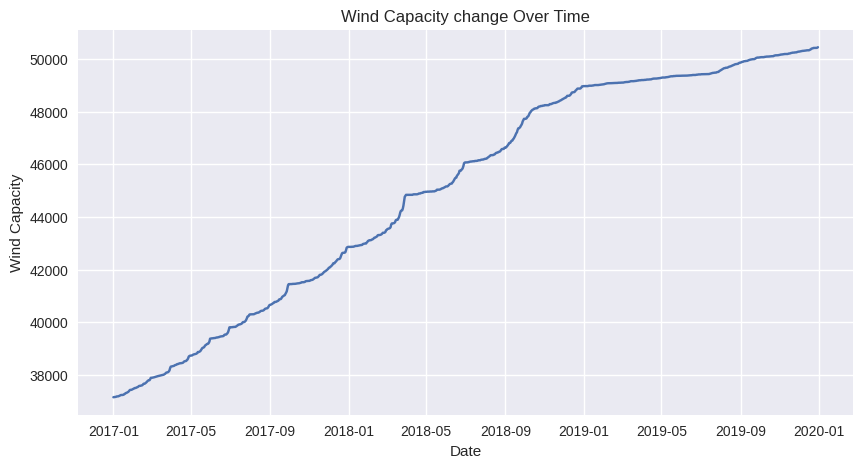

In [ ]:
#visualize wind capacity over time
fig = plt.figure(figsize=(10,5))
plt.plot(wind_power_df.index, wind_power_df['wind_capacity'])
plt.xlabel('Date')
plt.ylabel('Wind Capacity')
plt.title('Wind Capacity change Over Time')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

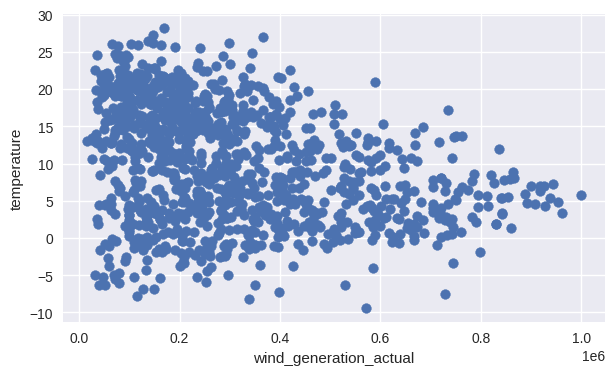

In [ ]:
#checks the relationship between actual wind generation and temperature
plt.figure(figsize=(7,4))
plt.scatter(wind_power_df['wind_generation_actual'], wind_power_df['temperature'])
plt.xlabel('wind_generation_actual')
plt.ylabel('temperature');

## ***Observation:*** There is no strong relationship between actutal wind generation and temperature

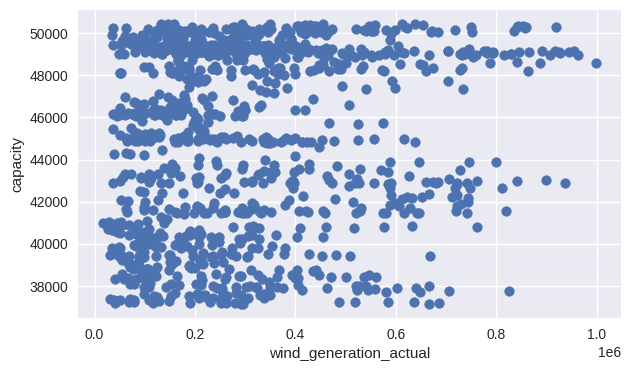

In [ ]:
#checks the relationship between actual wind generation and wind capacity
plt.figure(figsize=(7,4))
plt.scatter(wind_power_df['wind_generation_actual'], wind_power_df['wind_capacity'])
plt.xlabel('wind_generation_actual')
plt.ylabel('capacity');

## ***Observation:*** there is no strong relationship between these actual wind generation and capacity.

In [ ]:
# Check Pearson Correlation coefficient for wind generation and capacity
x = wind_power_df['wind_generation_actual']
y = wind_power_df['wind_capacity']

corr_value, p_value = pearsonr(x, y)

capacity_generation_corrcoef = np.corrcoef(x, y)
display(capacity_generation_corrcoef)

print('Correlation value [Python] is:', capacity_generation_corrcoef[0, 1])
print('P-value is:', p_value)

array([[1.       , 0.1277082],
       [0.1277082, 1.       ]])

Correlation value [Python] is: 0.12770819926061922
P-value is: 2.2696664084022654e-05


In [ ]:
# Check Pearson Correlation coefficient for wind generation and temperature
x = wind_power_df['wind_generation_actual']
y = wind_power_df['temperature']

corr_value, p_value = pearsonr(x, y)

capacity_generation_corrcoef = np.corrcoef(x, y)
display(capacity_generation_corrcoef)

print('Correlation value [Python] is:', capacity_generation_corrcoef[0, 1])
print('P-value is:', p_value)

array([[ 1.        , -0.32583062],
       [-0.32583062,  1.        ]])

Correlation value [Python] is: -0.32583061587424406
P-value is: 1.7898515987123048e-28


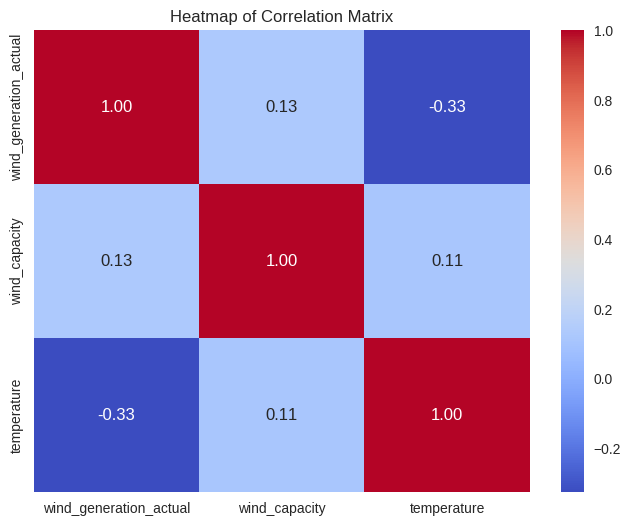

In [ ]:
correlation_matrix = wind_power_df[['wind_generation_actual', 'wind_capacity', 'temperature']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Heatmap of Correlation Matrix")
plt.show()

## ***Observation:***
##Wind Generation and Capacity:
Correlation value:
0.1277(positive but weak).
A small positive correlation indicates that there is a slight tendency for wind generation to increase as capacity increases, but the relationship is very weak.

P-value:
2.2696664084022654e-05(very small).
This small p-value suggests the correlation is statistically significant(reject null hypotheis), meaning the weak positive relationship observed is unlikely to be due to random chance.
## Wind Generation and Temperature:
Correlation value: −0.3258 (negative moderate).
A moderate negative correlation indicates that wind generation tends to decrease as temperature increases.
P-value: 1.7898515987123048e-28(extremely small).
This extremely small p-value confirms that the negative correlation is statistically significant, and the relationship is not due to random variation.

These findings are statistically significant, so they provide meaningful insights into the relationships between the variables. However, correlations are not strong.

<ipython-input-73-4ca3a2b9ee45>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  wind_power_df['Period_Y'] = wind_power_df.index.to_period('Y')


wind_generation_actual  wind_capacity  temperature  \
utc_timestamp                                                                   
2017-01-01 00:00:00+00:00                291760.0      37149.130       -2.117   
2017-01-02 00:00:00+00:00                295097.0      37152.125       -1.154   
2017-01-03 00:00:00+00:00                666170.0      37155.208       -0.239   
2017-01-04 00:00:00+00:00                686581.0      37160.125        0.620   
2017-01-05 00:00:00+00:00                261759.0      37163.542       -3.908   
...                                           ...            ...          ...   
2019-12-26 00:00:00+00:00                132739.0      50424.125        2.790   
2019-12-27 00:00:00+00:00                146590.0      50427.000        1.327   
2019-12-28 00:00:00+00:00                159126.0      50427.292       -1.441   
2019-12-29 00:00:00+00:00                349839.0      50434.750       -1.314   
2019-12-30 00:00:00+00:00                639343.0      50452.000        0.542   

                          Period_Y  
utc_timestamp                       
2017-01-01 00:00:00+00:00     2017  
2017-01-02 00:00:00+00:00     2017  
2017-01-03 00:00:00+00:00     2017  
2017-01-04 00:00:00+00:00     2017  
2017-01-05 00:00:00+00:00     2017  
...                            ...  
2019-12-26 00:00:00+00:00     2019  
2019-12-27 00:00:00+00:00     2019  
2019-12-28 00:00:00+00:00     2019  
2019-12-29 00:00:00+00:00     2019  
2019-12-30 00:00:00+00:00     2019  

[1094 rows x 4 columns]

<ipython-input-73-4ca3a2b9ee45>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=wind_power_df['Period_Y'], y = wind_power_df['wind_generation_actual'],palette='rainbow');


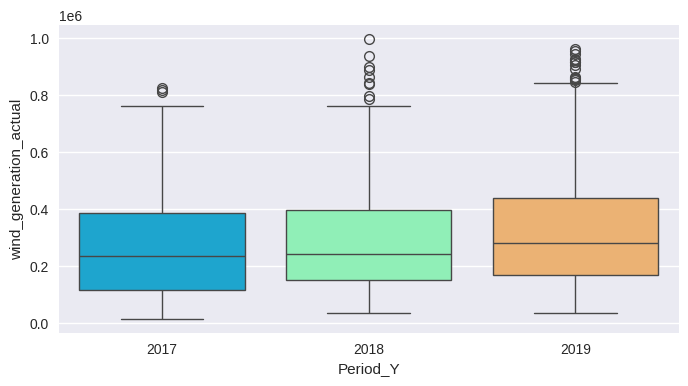

In [73]:
#add column with year sperated to plot the box plot to check the distribution of data
wind_power_df['Period_Y'] = wind_power_df.index.to_period('Y')
display(wind_power_df)

plt.figure(figsize=(8,4))
sns.boxplot(x=wind_power_df['Period_Y'], y = wind_power_df['wind_generation_actual'],palette='rainbow');

## ***Observation:*** Each year there are outliers, but in 2018 and 2019 more outliers can be seen and the increment in ranges also noticable in 2019.

<ipython-input-33-cefbeee37a45>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wind_power_df['Period_Y'] , y = wind_power_df['wind_generation_actual'] ,palette='autumn',errorbar=('se'),capsize=0.01,estimator='mean')


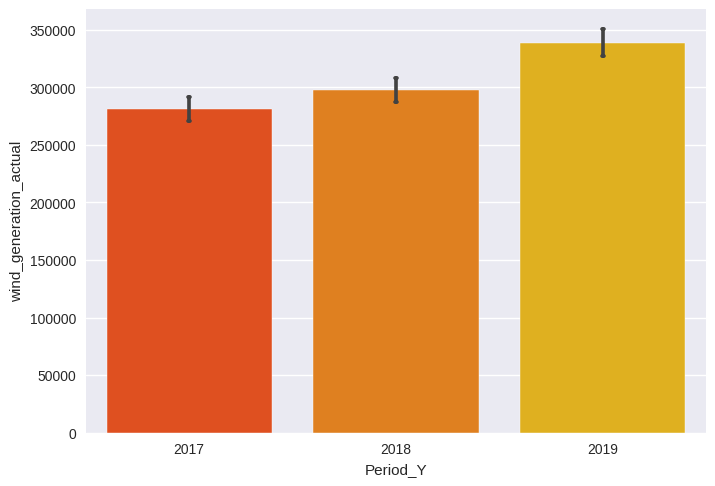

In [ ]:
#bar plot to see each year's wind generation visually
sns.barplot(x=wind_power_df['Period_Y'] , y = wind_power_df['wind_generation_actual'] ,palette='autumn',errorbar=('se'),capsize=0.01,estimator='mean')
plt.show()

## ***Observation:*** Each year the generation increases.


Text(0, 0.5, 'Counts')

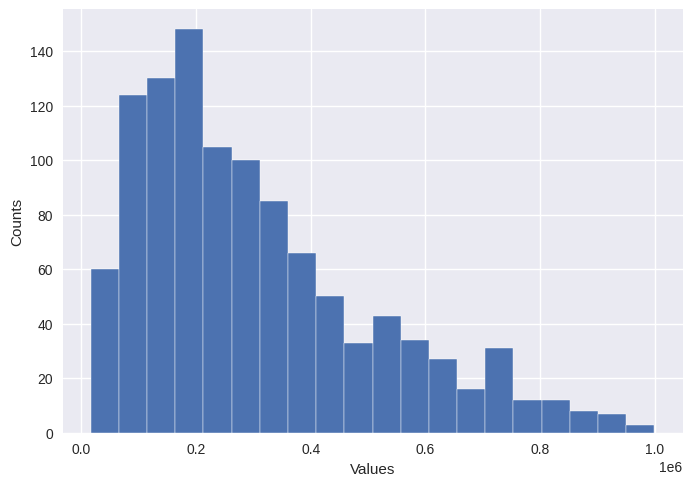

In [ ]:
#historgrams to check the distribution
plt.hist(wind_power_df['wind_generation_actual'], bins = 20, density=False)
plt.xlabel('Values')
plt.ylabel('Counts')

## ***Observation:*** Data are skewed meaning more generated amount is in left range.


In [ ]:
#lag plots to check series has pattern
lag_check = [{'name': 'Lag0', 'y': wind_power_df['wind_generation_actual'],'color':'k', 'linewidth':2},
            {'name': 'Lag2', 'y':  wind_power_df['wind_generation_actual'].shift(7),'color':'b', 'linewidth':2}, #7 days
             {'name': 'Lag4', 'y':  wind_power_df['wind_generation_actual'].shift(30),'color':'c', 'linewidth':2}, #month
             ]

lag_check[1]

{'name': 'Lag2',
 'y': date
 2017-01-01         NaN
 2017-01-02         NaN
 2017-01-03         NaN
 2017-01-04         NaN
 2017-01-05         NaN
                 ...   
 2019-12-26    558192.0
 2019-12-27    653405.0
 2019-12-28    429207.0
 2019-12-29    419774.0
 2019-12-30    612081.0
 Freq: D, Name: wind_generation_actual, Length: 1094, dtype: float64,
 'color': 'b',
 'linewidth': 2}

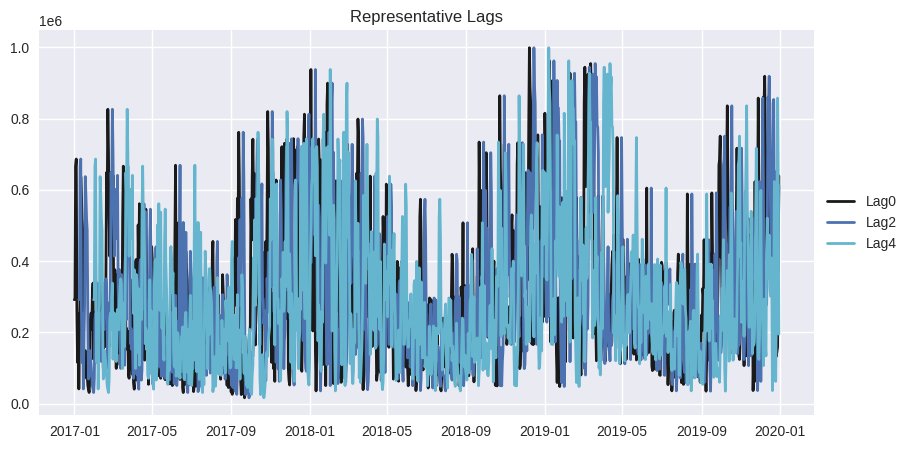

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for line_lag in lag_check:
    ax.plot(line_lag['y'],
            color=line_lag['color'],
            linewidth=line_lag['linewidth'],
            label=line_lag['name'])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Representative Lags');

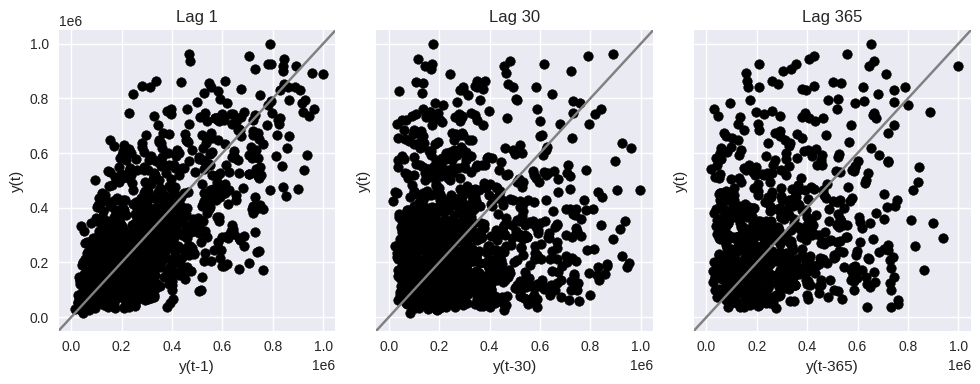

In [ ]:
fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,4))

lags = [1 ,30, 365]
for i, lag in enumerate(lags):
    ax = axes[i]
    lag_plot(wind_power_df['wind_generation_actual'], lag=lag, ax=ax, c='black')
    ax.set_xlabel(f'y(t-{lag})')
    ax.set_ylabel('y(t)')
    ax.set_title(f'Lag {lag}')
    pt = (350, 350)
    ax.axline(pt, slope=1, color='gray')

plt.tight_layout()
plt.show()

## ***Observation:*** In lag 1 that is a day before data has some correlation with lag 0 data, and when the lag increases like to 30 that is a month, it changes, and then a year again its starts to correlate.


In [ ]:
#Checked on resample data also for furthur analysis - Monthly resampled
lag_check_M = [{'name': 'Lag0', 'y': wind_power_df_resampled,'color':'k', 'linewidth':2},
            {'name': 'Lag2', 'y':  wind_power_df_resampled.shift(1),'color':'b', 'linewidth':2},
             {'name': 'Lag4', 'y':  wind_power_df_resampled.shift(12),'color':'c', 'linewidth':2},
             ]

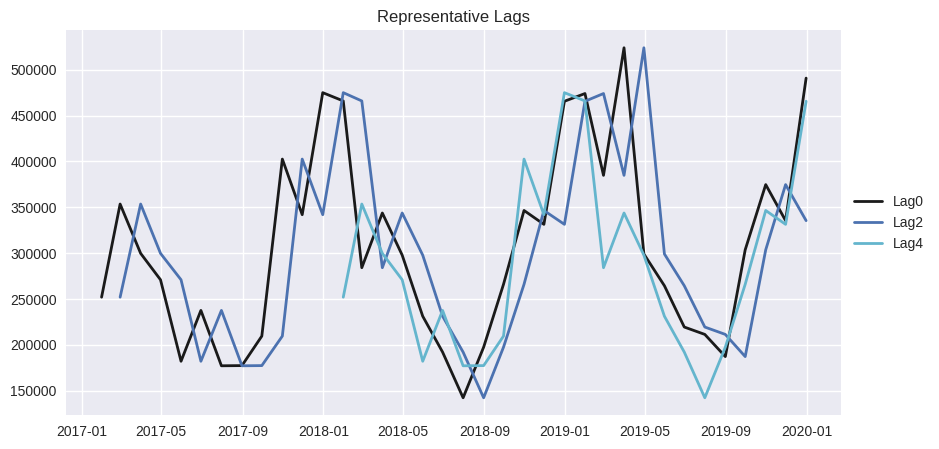

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for line_lag in lag_check_M:
    ax.plot(line_lag['y'],
            color=line_lag['color'],
            linewidth=line_lag['linewidth'],
            label=line_lag['name'])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Representative Lags');

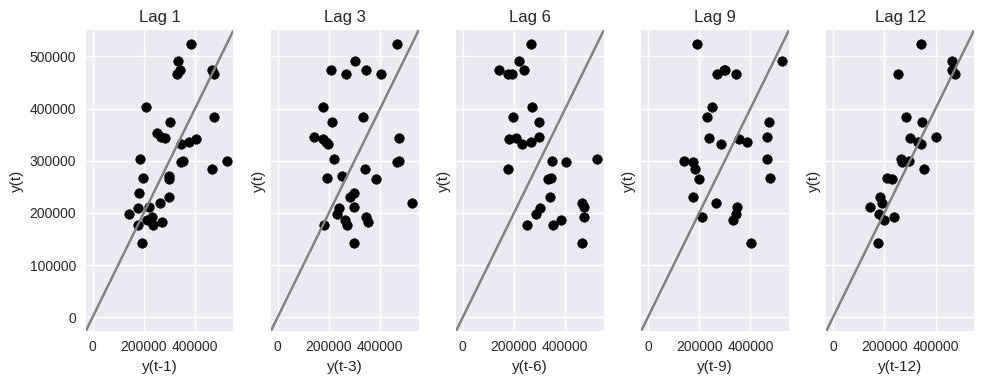

In [ ]:
fig, axes = plt.subplots(1,5, sharex=True, sharey=True, figsize=(10,4))

lags = [1,3,6,9,12]
for i, lag in enumerate(lags):
    ax = axes[i]
    lag_plot(wind_power_df_resampled, lag=lag, ax=ax, c='black')
    ax.set_xlabel(f'y(t-{lag})')
    ax.set_ylabel('y(t)')
    ax.set_title(f'Lag {lag}')
    pt = (350, 350)
    ax.axline(pt, slope=1, color='gray')

plt.tight_layout()
plt.show()

## ***Observation:*** In the 12 moths lag, it shows a strong relationship.


array([1.        , 0.68157279, 0.43027977, 0.30676262, 0.24758269,
       0.19749192, 0.17063462, 0.17923591, 0.17899879, 0.17004863,
       0.14363602, 0.11950614, 0.13177853, 0.13705606, 0.13219531,
       0.13662269, 0.13383934, 0.13316963, 0.1146174 , 0.10125789,
       0.13042274, 0.17450499, 0.17323675, 0.18639117, 0.20915417,
       0.22309975, 0.21864606, 0.19323431, 0.14574529, 0.10591218,
       0.08862739, 0.093652  , 0.10876459, 0.12373756, 0.12591058,
       0.13351147, 0.16634375, 0.16752192, 0.15609979, 0.13430081,
       0.11740587, 0.12963775, 0.14586685, 0.12547039, 0.12176455,
       0.1412356 , 0.16651949, 0.13589825, 0.13101295, 0.14168371,
       0.13549343, 0.10195836, 0.0902475 , 0.07255541, 0.05658969,
       0.04809532, 0.06893572, 0.12376247, 0.15860051, 0.16695704,
       0.16085197, 0.13762587, 0.13889721, 0.1382949 , 0.11743331,
       0.1071788 , 0.1175579 , 0.13599034, 0.11726992, 0.11055371,
       0.10359771])

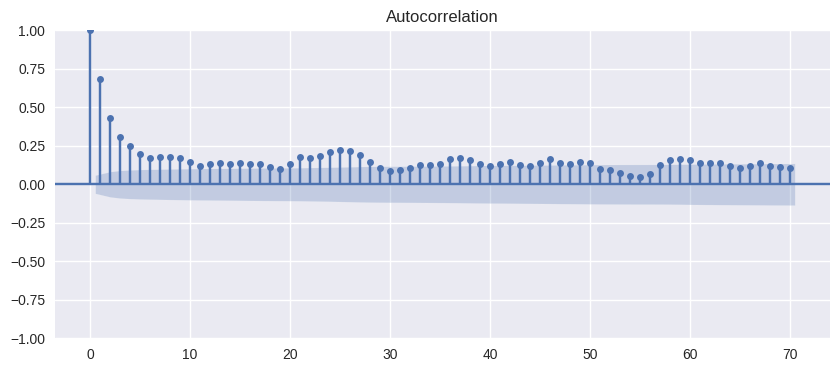

In [ ]:
#ACF to check correlation with previous values
fig, ax = plt.subplots(figsize=(10,4))
plot_acf(wind_power_df['wind_generation_actual'], lags=70,ax=ax);

val = acf(wind_power_df['wind_generation_actual'],nlags=70)
display(val)

## ***Observation:*** It shows spikes for around 7 days then again in aorund 25 days. This does not look stationary, but later do KPSS and ADF tests to check.

array([ 1.        ,  0.55970358,  0.37587668,  0.05593611, -0.34829599,
       -0.53904123, -0.56152009, -0.49474347, -0.32850544,  0.0561095 ])

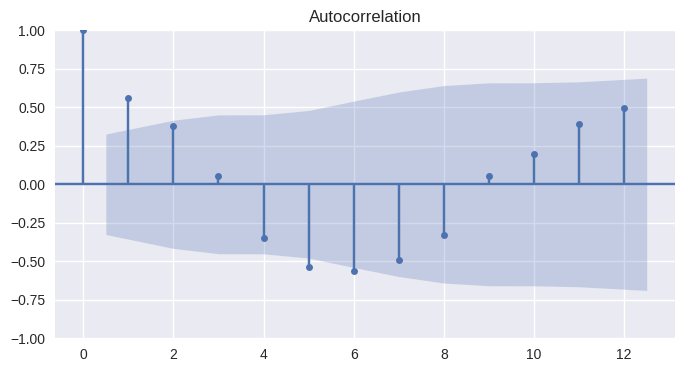

In [ ]:
#On monthly resampled data for just checking
fig, ax = plt.subplots(figsize=(8,4))
plot_acf(wind_power_df_resampled, lags=12,ax=ax);

val = acf(wind_power_df_resampled,nlags=9)
display(val)

## ***Observation:*** It shows spikes in month 1 and 5.

# **Seasonality Check**

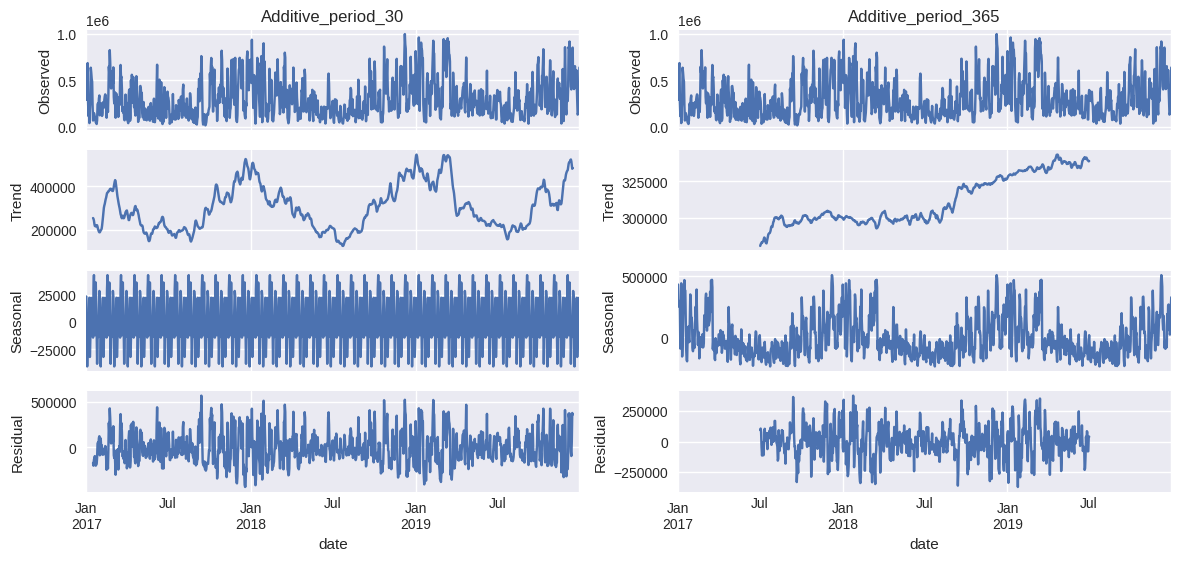

In [ ]:
decompose_data_add_30 = seasonal_decompose(wind_power_df['wind_generation_actual'], model='additive', period=30)
decompose_data_add_365 = seasonal_decompose(wind_power_df['wind_generation_actual'], model='additive', period=365)

def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')


fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(14,6))
plotseasonal(decompose_data_add_30, axes[:,0])
axes[0,0].set_title('Additive_period_30')
plotseasonal(decompose_data_add_365, axes[:,1])
axes[0,1].set_title('Additive_period_365');

## ***Observation:*** The plots on decompositions on both monthly and yearly seasonal periods show a clear seasonality. Thus in order furthur confirm this, uses FFT and PSD as follows.

Text(0, 0.5, 'FFT Amplitude |X(freq)|')

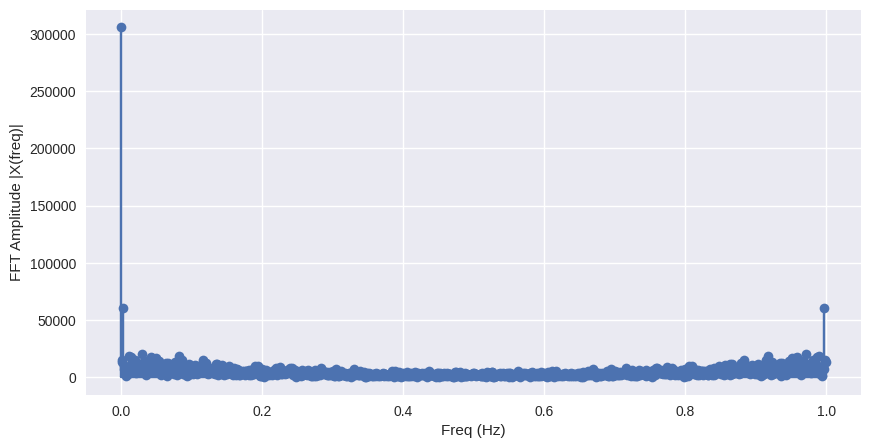

In [ ]:
from numpy.fft import fft, ifft

Fs=1
X = fft(wind_power_df['wind_generation_actual'])
N = len(X)
freq_step = Fs/N;
freq_vec = np.arange(0,Fs,freq_step)

plt.figure(figsize = (10,5))

plt.stem(freq_vec, np.abs(X)/N, 'b', basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

Frequency for the maximum value is:  0.002742230347349177
Period (months/cycle):  364.6666666666667


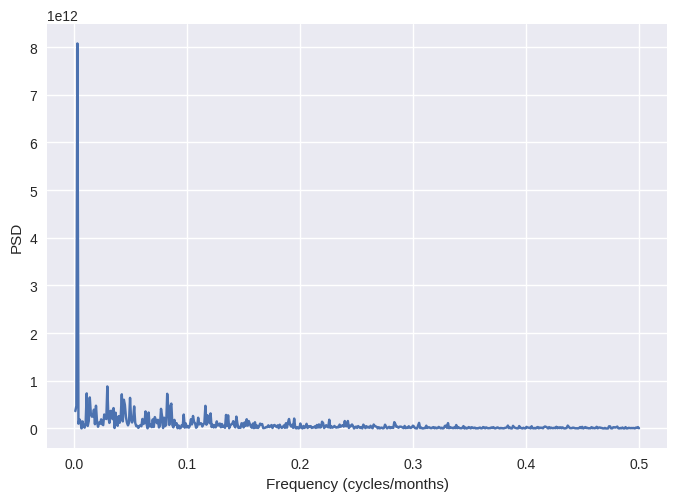

In [ ]:
from scipy.signal import periodogram

f_per, Pxx_per = periodogram(wind_power_df['wind_generation_actual'],Fs,detrend=False,window='boxcar',return_onesided=True,scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

plt.plot(f_per, Pxx_per)
plt.xlabel('Frequency (cycles/months)')
plt.ylabel('PSD');

temp = np.argmax(Pxx_per)
max_frequency = f_per[temp]
max_period = 1 / max_frequency

print('Frequency for the maximum value is: ', max_frequency)
print('Period (months/cycle): ', max_period)

## ***Observation:*** As seen in FFT and PSD, it is confirmed that there is a yearly seasonality as the time with maximum frequency is approximately 365 days, which is a year.

Freq      Period         Power
0    0.002742  364.666667  8.076796e+12
10   0.029250   34.187500  8.815731e+11
3    0.010969   91.166667  7.359464e+11
30   0.082267   12.155556  7.275789e+11
15   0.042048   23.782609  7.168410e+11
..        ...         ...           ...
143  0.397623    2.514943  1.475941e+10
170  0.490859    2.037244  1.377669e+10
146  0.407678    2.452915  1.132507e+10
165  0.469835    2.128405  1.127392e+10
138  0.377514    2.648910  1.038215e+10

[172 rows x 3 columns]

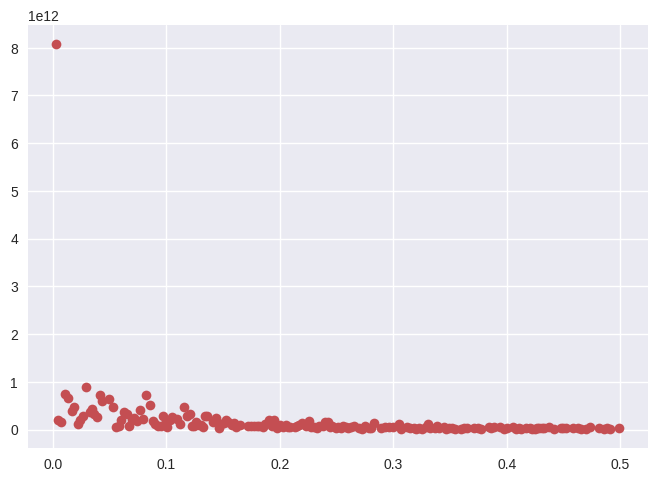

In [ ]:
from scipy.signal import find_peaks

peaks = find_peaks(Pxx_per[f_per >=0], prominence=max(Pxx_per)*0.001)[0]
peak_freq =  f_per[peaks]
peak_power = Pxx_per[peaks]
plt.plot(peak_freq, peak_power, 'ro');

data = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
df = pd.DataFrame(data)
display(df.sort_values(by='Power',ascending=False))

## ***Observation:*** Apart from checking only the cycle with maximum frequency, when check for all, the frequency for the maximum value (0.002742) and its corresponding period (364.67 months) represent the dominant long-term cycle (likely yearly seasonality). The second frequency (0.029250) has higher power and represents a shorter cycle (around 34 days).

# **Moving Average Smoothing - Smooth out trend**

In [19]:
wind_power_df['365-MA'] = wind_power_df['wind_generation_actual'].rolling(365, center=True).mean()

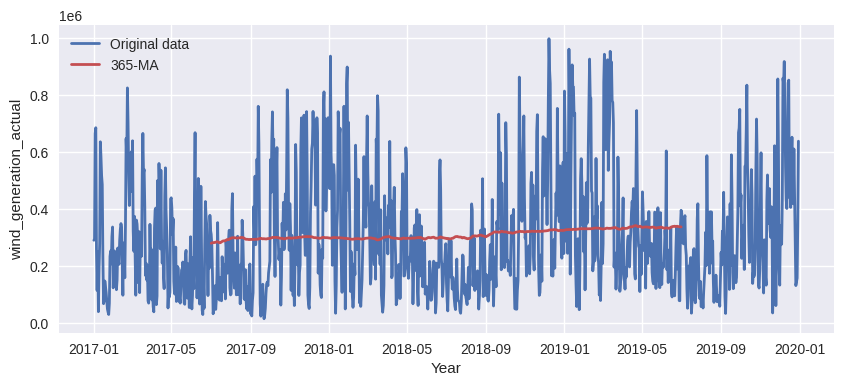

In [20]:
plt.figure(figsize=(10,4))
plt.plot(wind_power_df['wind_generation_actual'],'b-',label = 'Original data', linewidth=2)
plt.plot(wind_power_df['365-MA'],'r-',label = '365-MA', linewidth=2)
plt.legend()
plt.xlabel('Year')
plt.ylabel('wind_generation_actual');

# **Remark:** Use 365 to remove completely the seasonality and check the trend. There is a slightly increasing trend.

In [16]:
wind_power_df.drop(columns='365-MA', inplace=True)

# **Stationarity check**

In [ ]:
# ADF and KPSS
adf_test = adfuller(wind_power_df['wind_generation_actual'],autolag='AIC')
kpss_test = kpss(wind_power_df['wind_generation_actual'], regression='c', nlags='auto', store=True)
kpss_test_trend = kpss(wind_power_df['wind_generation_actual'], regression='ct', nlags='auto', store=True)
print('ADF p-value: ', adf_test[1])
print('KPSS p-value: ', kpss_test[1])
print('KPSS_trend p-value: ', kpss_test_trend[1])

ADF p-value:  3.5505256768540245e-13
KPSS p-value:  0.08499363675211812
KPSS_trend p-value:  0.07592615207862771


Text(0.5, 0.98, 'ACF-PACF for wind generation')

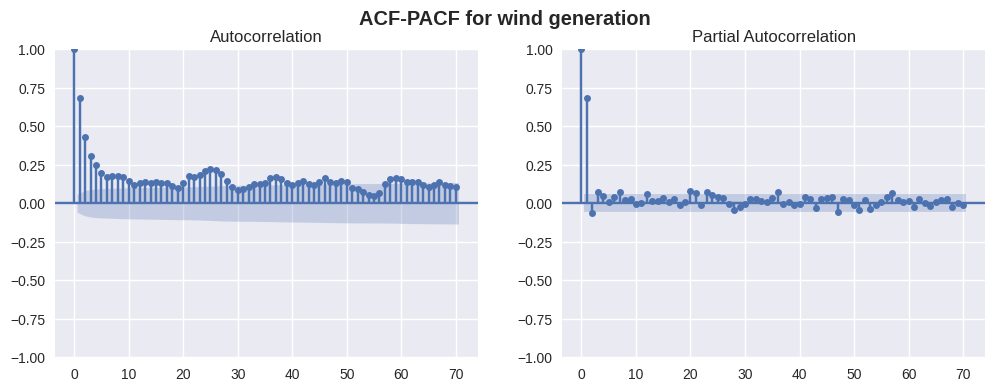

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
plot_acf(wind_power_df['wind_generation_actual'], lags=70, ax=ax[0])
plot_pacf(wind_power_df['wind_generation_actual'], lags=70, ax=ax[1])
plt.suptitle('ACF-PACF for wind generation', weight='bold')

## ***Observation:*** Dataset is stationary.

### **ADF Test:**
### ADF p-value = 3.55e-13, which is very small, so reject the null hypothesis and conclude that the series is stationary.

### **KPSS Test:**
### KPSS p-value = 0.085, which is greater than 0.05, so fail to reject the null hypothesis, suggesting the series is stationary at the level.

### **KPSS Trend:**
### KPSS_trend p-value = 0.0759, which is greater than 0.05, suggesting the series is trend stationary.

### The series appears to be stationary based on both the ADF and KPSS tests.
### The ADF test suggests it is stationary (rejecting the null hypothesis of non-stationarity), while the KPSS tests (both level and trend) support stationarity as well.

## ***Remark:*** However since the ACF plot seems non stationary, check differencing

In [ ]:
wind_power_df_ = wind_power_df.copy()

In [ ]:
wind_power_df_ = wind_power_df_.drop(['wind_capacity', 'temperature', 'Period_Y'], axis=1)

In [ ]:
wind_diff = wind_power_df_.diff().dropna() #first differencing

In [ ]:
adf_test_diff = adfuller(wind_diff,autolag='AIC')
kpss_test_diff = kpss(wind_diff, regression='c', nlags='auto', store=True)
kpss_test_trend_diff = kpss(wind_diff, regression='ct', nlags='auto', store=True)
print('ADF p-value: ', adf_test_diff[1])
print('KPSS p-value: ', kpss_test_diff[1])
print('KPSS_trend p-value: ', kpss_test_trend_diff[1])

ADF p-value:  4.964686198868169e-23
KPSS p-value:  0.1
KPSS_trend p-value:  0.1


<ipython-input-52-d62ed389cfae>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_diff = kpss(wind_diff, regression='c', nlags='auto', store=True)
<ipython-input-52-d62ed389cfae>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_trend_diff = kpss(wind_diff, regression='ct', nlags='auto', store=True)


Text(0.5, 0.98, 'ACF-PACF for wind generation')

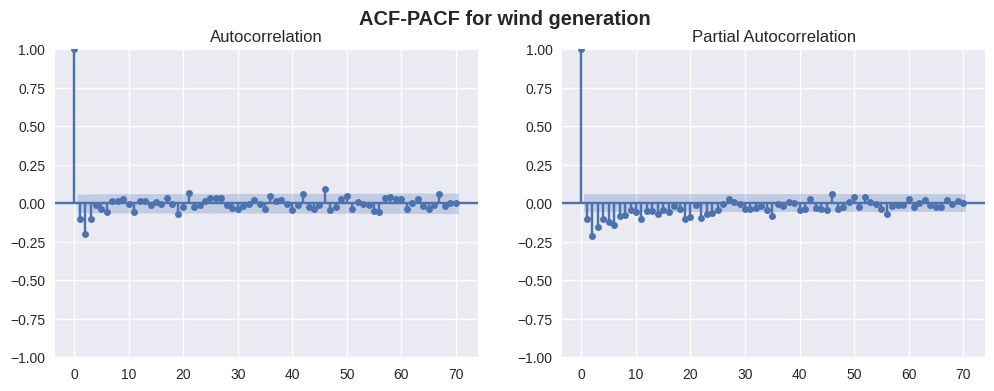

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
plot_acf(wind_diff, lags=70, ax=ax[0])
plot_pacf(wind_diff, lags=70, ax=ax[1])
plt.suptitle('ACF-PACF for wind generation', weight='bold')

## ***Remark:*** ACF and PACF plots appear to be more stationary, but ADF test did not give a valid output.

# **Train/Test Split**

In [37]:
#Last month as the test set
train = wind_power_df.loc[:'2019-11-30']
test = wind_power_df.loc['2019-12-01':]

In [ ]:
test

wind_generation_actual  wind_capacity  temperature Period_Y
date                                                                   
2019-12-01                134296.0      50285.250        0.198     2019
2019-12-02                344119.0      50291.417        0.874     2019
2019-12-03                275830.0      50301.083        2.077     2019
2019-12-04                278977.0      50303.167        0.673     2019
2019-12-05                436209.0      50307.208       -0.832     2019
2019-12-06                860237.0      50312.167        1.387     2019
2019-12-07                841616.0      50316.000        5.431     2019
2019-12-08                918908.0      50316.125        6.319     2019
2019-12-09                749939.0      50319.000        5.104     2019
2019-12-10                550224.0      50319.125        1.433     2019
2019-12-11                436289.0      50322.292        0.996     2019
2019-12-12                403284.0      50329.250        1.360     2019
2019-12-13                555000.0      50335.000        0.856     2019
2019-12-14                843230.0      50335.000        3.361     2019
2019-12-15                853649.0      50335.000        5.460     2019
2019-12-16                441369.0      50335.417        5.238     2019
2019-12-17                546881.0      50345.667        7.553     2019
2019-12-18                407039.0      50361.375        6.188     2019
2019-12-19                558192.0      50371.208        5.734     2019
2019-12-20                653405.0      50399.167        6.222     2019
2019-12-21                429207.0      50403.250        4.585     2019
2019-12-22                419774.0      50409.625        4.509     2019
2019-12-23                612081.0      50424.000        5.284     2019
2019-12-24                455192.0      50424.000        5.067     2019
2019-12-25                293649.0      50424.000        4.728     2019
2019-12-26                132739.0      50424.125        2.790     2019
2019-12-27                146590.0      50427.000        1.327     2019
2019-12-28                159126.0      50427.292       -1.441     2019
2019-12-29                349839.0      50434.750       -1.314     2019
2019-12-30                639343.0      50452.000        0.542     2019

# **Seasonal Naive**

## **Remark:** Before moving to complex models like ARIMA, SARIMA and SARIMAX first check with a basic model like Seasonal Naive and ETS(Exponential Triple smoothing).

array([454201., 648286., 609178., 487258., 346902., 500778., 787334.,
       998899., 888048., 842063., 476052., 167250., 263039., 165798.,
       283693., 294833., 193625., 343368., 457762., 378972., 754430.,
       519328., 405051., 356747., 552750., 403203., 282809., 228763.,
       533095., 565673.])

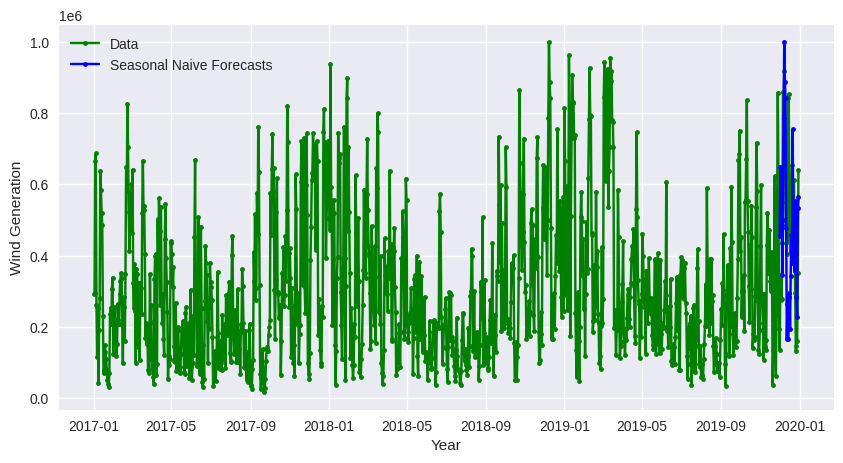

In [65]:
model_NaiveS = SeasonalNaive(season_length=365)
model_NaiveS = model_NaiveS.fit(train['wind_generation_actual'])

forecast_values = model_NaiveS.predict(len(test))

display(forecast_values['mean'])

plt.figure(figsize=(10,5))
plt.plot(wind_power_df.index, wind_power_df['wind_generation_actual'], color='green', marker='.', label='Data')
plt.plot(test.index, forecast_values['mean'], color='blue', marker='.', label='Seasonal Naive Forecasts')
plt.xlabel('Year')
plt.ylabel('Wind Generation')
plt.legend()
plt.show()

In [66]:
print('RMSE Naive_seasonal):', root_mean_squared_error(test['wind_generation_actual'], forecast_values['mean']))
print('MAPE Naive_seasonal):', 100*mean_absolute_percentage_error(test['wind_generation_actual'], forecast_values['mean']))

RMSE Naive_seasonal): 266650.9468335587
MAPE Naive_seasonal): 58.642913560065544


In [51]:
residuals = test['wind_generation_actual'] - forecast_values['mean']

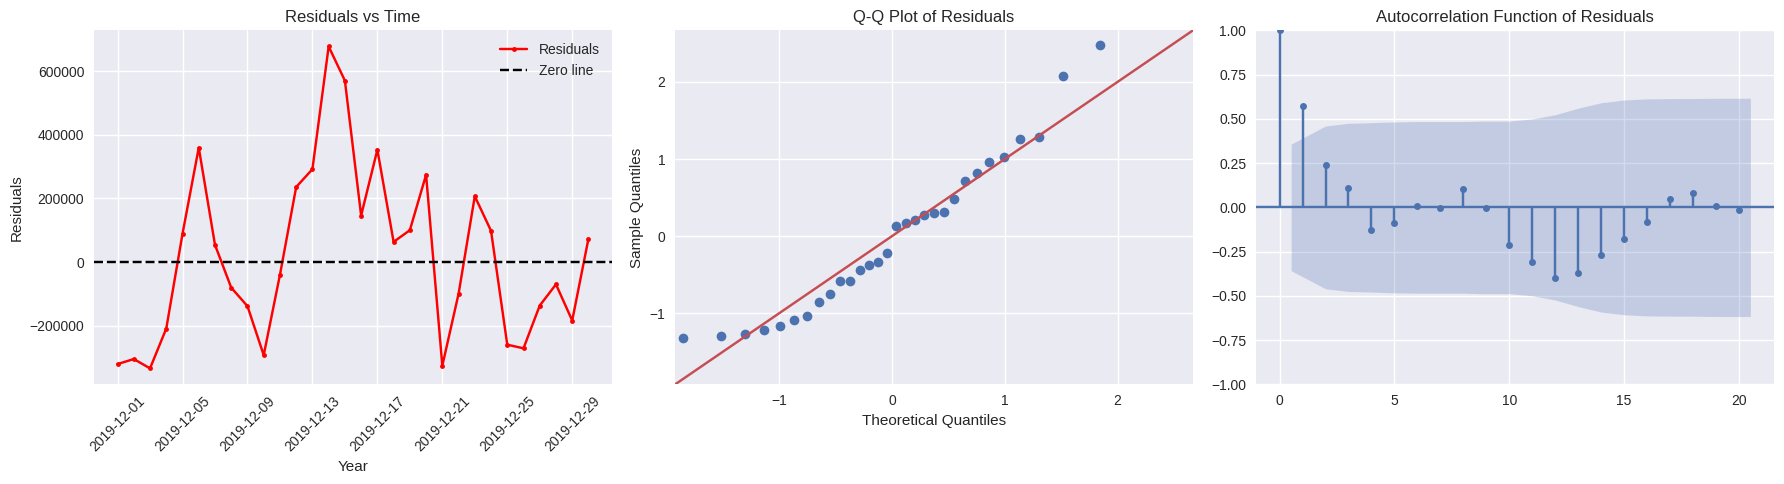

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(test.index, residuals, color='red', marker='.', label='Residuals')
axes[0].axhline(y=0, color='black', linestyle='--', label='Zero line')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Residuals')
axes[0].legend()
axes[0].set_title('Residuals vs Time')
axes[0].tick_params(axis='x', rotation=45)

# Q-Q Plot of Residuals
sm.qqplot(residuals, line='45', fit=True, ax=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')

# Autocorrelation Function (ACF) of Residuals
plot_acf(residuals, lags=20, ax=axes[2])
axes[2].set_title('Autocorrelation Function of Residuals')

plt.tight_layout()
plt.show()

In [54]:
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat}")

Durbin-Watson Statistic: 0.7981291130181742


In [55]:
ljung_box_stat = acorr_ljungbox(residuals, lags=10)
print(ljung_box_stat)

      lb_stat  lb_pvalue
1   10.813007   0.001008
2   12.749639   0.001704
3   13.188252   0.004247
4   13.772563   0.008057
5   14.073982   0.015146
6   14.075203   0.028807
7   14.075492   0.049855
8   14.564884   0.068179
9   14.566020   0.103567
10  16.686840   0.081587


### Evaluate the residuals and plot them to check that the assumptions of the model have been satisfied.

**General assumptions:** they have mean zero; they are not autocorrelated; they are unrelated to the predictor variables. It is also useful to have the errors being normally distributed with a constant variance.

## ***Observation:***


*  ##  The ACF plot for residuals is not a white noise, so correlated and residuals do not fit well in the QQ-plot.

*  ## Durbin-Watson Statistic (0.798) suggests that there is positive autocorrelation in the residuals.


        DW = 2: No autocorrelation.

        DW < 2: Positive autocorrelation (residuals are correlated with each other).

        DW > 2: Negative autocorrelation (residuals are negatively correlated with each other).




*   ## The Ljung-Box test shows significant autocorrelation at lag 1, but after that, the residuals seem to become independent (no autocorrelation) at higher lags.
        H0: No autocorrelation

## **Conclusion**: Even the performance is good, the model is not good according to DW test.

# **ETS**

## ***Remark:***  Try both damped=True and false and check for AIC value and choose the better one with lower AIC. Here uses ETS(A,A,A) model.

In [ ]:
model_ETS = ETSModel(train['wind_generation_actual'], error = 'add', trend='add', damped_trend=False, seasonal='add',seasonal_periods=365).fit()

Param Name         Values
0         smoothing_level       0.725835
1         smoothing_trend       0.000073
2      smoothing_seasonal       0.274137
3           initial_level  280929.003105
4           initial_trend     540.994604
..                    ...            ...
365  initial_seasonal.360 -327259.104109
366  initial_seasonal.361 -215210.238356
367  initial_seasonal.362 -137377.145206
368  initial_seasonal.363     -54.947945
369  initial_seasonal.364       0.000000

[370 rows x 2 columns]

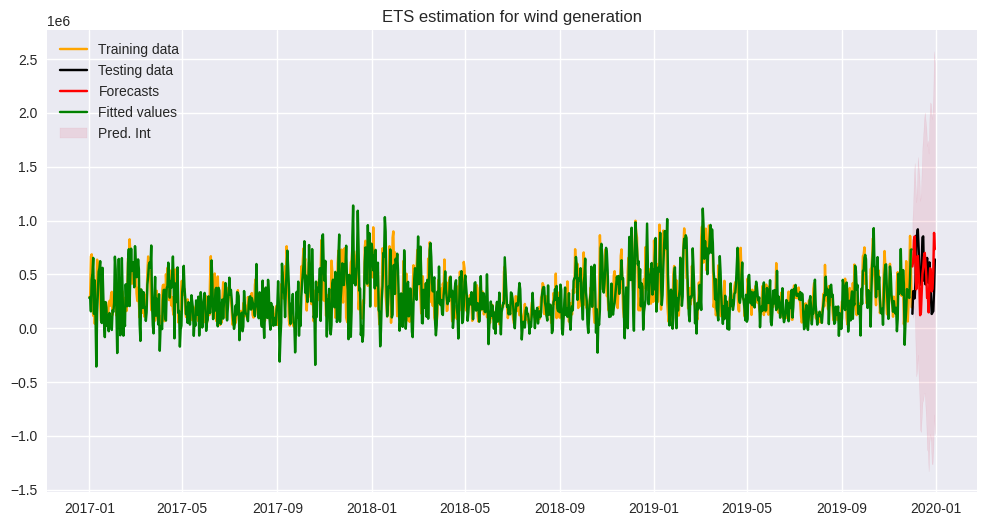

In [ ]:
pred_ETS = model_ETS.get_prediction(start=test.index[0], end=test.index[-1])
df_ETS = pred_ETS.summary_frame()
predictions = df_ETS['mean']

parameters_df = {'Param Name': model_ETS.param_names, 'Values': model_ETS.params}
parameters_df = pd.DataFrame(parameters_df)
display(parameters_df)

fig = plt.figure(figsize=(12,6))
plt.plot(train['wind_generation_actual'], color='orange',label='Training data')
plt.plot(test['wind_generation_actual'], color='black', label='Testing data')
plt.plot(predictions, color='red', label='Forecasts')
plt.plot(model_ETS.fittedvalues,color='green', label='Fitted values')
plt.fill_between(df_ETS.index, df_ETS['pi_lower'], df_ETS['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.title('ETS estimation for wind generation')
plt.legend(loc='upper left');

In [ ]:
model_ETS_damped = ETSModel(train['wind_generation_actual'], error = 'add', trend='add', damped_trend=True, seasonal='add',seasonal_periods=365).fit()

Param Name         Values
0         smoothing_level       0.725821
1         smoothing_trend       0.000073
2      smoothing_seasonal       0.274151
3           damping_trend       0.800000
4           initial_level  280929.003106
..                    ...            ...
366  initial_seasonal.360 -327259.104107
367  initial_seasonal.361 -215210.238353
368  initial_seasonal.362 -137377.145203
369  initial_seasonal.363     -54.947945
370  initial_seasonal.364       0.000000

[371 rows x 2 columns]

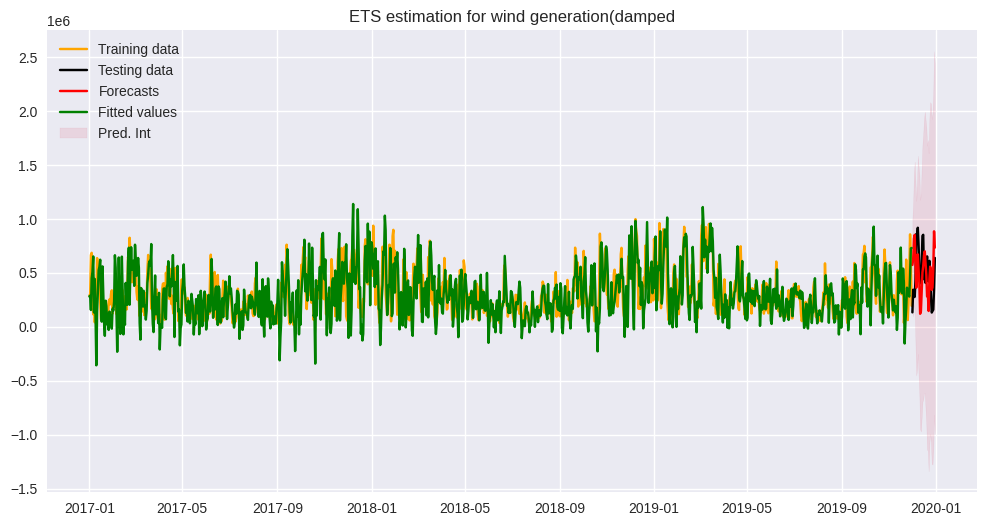

In [ ]:
pred_ETS_damped = model_ETS_damped.get_prediction(start=test.index[0], end=test.index[-1])
df_ETS_damped = pred_ETS_damped.summary_frame()
predictions_damped = df_ETS['mean']

parameters_df = {'Param Name': model_ETS_damped.param_names, 'Values': model_ETS_damped.params}
parameters_df = pd.DataFrame(parameters_df)
display(parameters_df)

fig = plt.figure(figsize=(12,6))
plt.plot(train['wind_generation_actual'], color='orange',label='Training data')
plt.plot(test['wind_generation_actual'], color='black', label='Testing data')
plt.plot(predictions_damped, color='red', label='Forecasts')
plt.plot(model_ETS_damped.fittedvalues,color='green', label='Fitted values')
plt.fill_between(df_ETS_damped.index, df_ETS_damped['pi_lower'], df_ETS_damped['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.title('ETS estimation for wind generation(damped')
plt.legend(loc='upper left');

## ***Observation:*** Both dumped=True and False appear to provide good results. Check for AIC value to choose and then check for the performance matrices of the chosen model.

In [ ]:
# Select the best model on the basis of the lowest AIC
print('AIC ETS(A,A,A):', model_ETS.aic)
print('AIC ETS(A,A,A)_damped:', model_ETS_damped.aic)

AIC ETS(A,A,A): 29905.45244252328
AIC ETS(A,A,A)_damped: 29907.384443501498


## ***Observation:*** There is a small difference. However choose ETS without damped as it has the lower AIC.

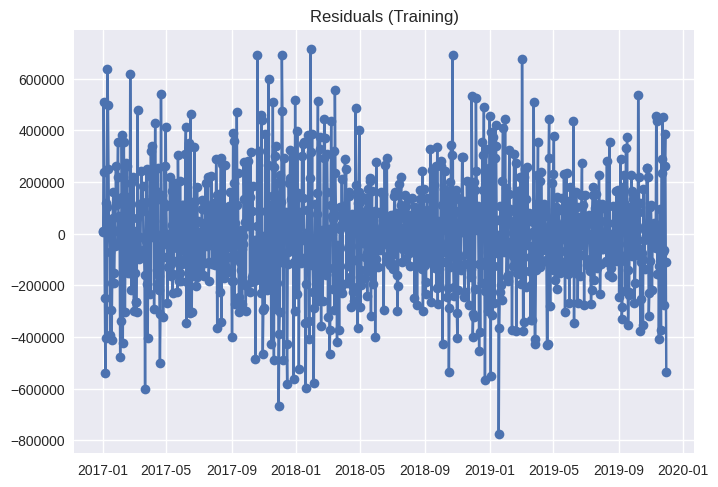

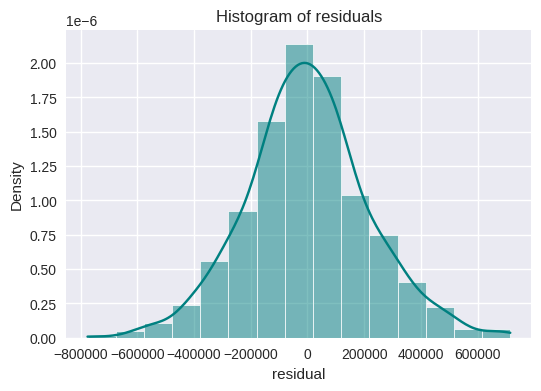

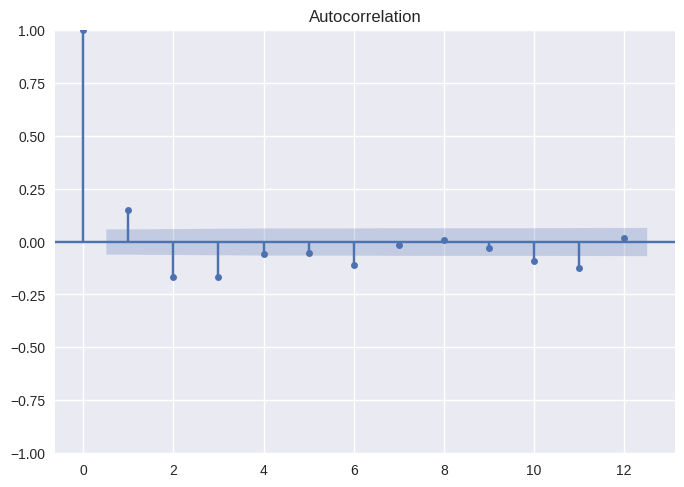

In [ ]:
# Visualise the residuals for the best model
plt.plot(model_ETS.resid,'o-b');
plt.title('Residuals (Training)')

# Histogram of the residuals
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(x=model_ETS.resid, stat='density', linewidth=0.5, kde=True,color='teal',bins=15)
ax.set(title='Histogram of residuals', xlabel='residual');

# ACF plot
plot_acf(model_ETS.resid,lags=12);

In [ ]:
#model_ETS.summary()

## ***Observation:*** The model should be stationary, but with the ACF plot, it is not white noise, that is the residuals are still correlated, thus not a good model.

In [ ]:
# Calculate RMSE and MAPE for both training and test set
print('Training')
print('RMSE ETS(A,A,A):', root_mean_squared_error(train['wind_generation_actual'], model_ETS.fittedvalues))
print('MAPE ETS(A,A,A):', 100*mean_absolute_percentage_error(train['wind_generation_actual'], model_ETS.fittedvalues))

print('Testing')
print('RMSE ETS(A,A,A):', root_mean_squared_error(test['wind_generation_actual'], df_ETS['mean']))
print('MAPE ETS(A,A,A):', 100*mean_absolute_percentage_error(test['wind_generation_actual'], df_ETS['mean']))

Training
RMSE ETS(A,A,A): 216574.82397609303
MAPE ETS(A,A,A): 87.4414549787474
Testing
RMSE ETS(A,A,A): 305971.0824696204
MAPE ETS(A,A,A): 80.16811409076163


# **ETS on differenced data**

## ***Remarks:*** Check ETS model on differenced data to evaluate the performance as an additional check.

In [ ]:
train_diff = wind_diff.loc[:'2019-11-30']
test_diff = wind_diff.loc['2019-12-01':]

In [ ]:
model_ETS_diff = ETSModel(train_diff['wind_generation_actual'], error = 'add', trend='add', damped_trend=False, seasonal='add',seasonal_periods=365).fit()

Param Name        Values
0         smoothing_level  2.967910e-03
1         smoothing_trend  2.967910e-07
2      smoothing_seasonal  4.237334e-01
3           initial_level  7.054122e+02
4           initial_trend -3.140337e+01
..                    ...           ...
365  initial_seasonal.360  1.526544e+05
366  initial_seasonal.361  1.184386e+05
367  initial_seasonal.362  1.779277e+05
368  initial_seasonal.363  4.066050e+04
369  initial_seasonal.364  0.000000e+00

[370 rows x 2 columns]

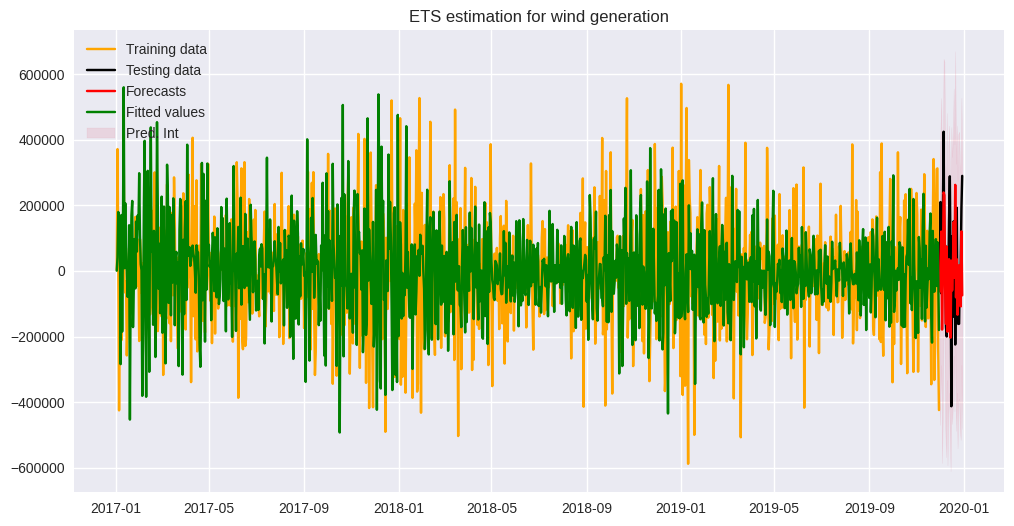

In [ ]:
# Forecasting in the future and prediction interval
pred_ETS_diff = model_ETS_diff.get_prediction(start=test.index[0], end=test.index[-1])
df_ETS_diff = pred_ETS_diff.summary_frame()
predictions_diff = df_ETS_diff['mean']

# Model parameters
parameters_df = {'Param Name': model_ETS_diff.param_names, 'Values': model_ETS_diff.params}
parameters_df = pd.DataFrame(parameters_df)
display(parameters_df)

fig = plt.figure(figsize=(12,6))
plt.plot(train_diff['wind_generation_actual'], color='orange',label='Training data')
plt.plot(test_diff['wind_generation_actual'], color='black', label='Testing data')
plt.plot(predictions_diff, color='red', label='Forecasts')
plt.plot(model_ETS_diff.fittedvalues,color='green', label='Fitted values')
plt.fill_between(df_ETS_diff.index, df_ETS_diff['pi_lower'], df_ETS_diff['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.title('ETS estimation for wind generation')
plt.legend(loc='upper left');

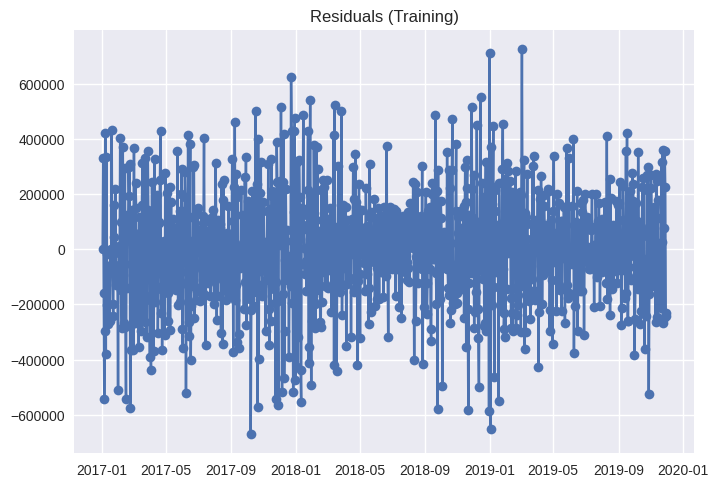

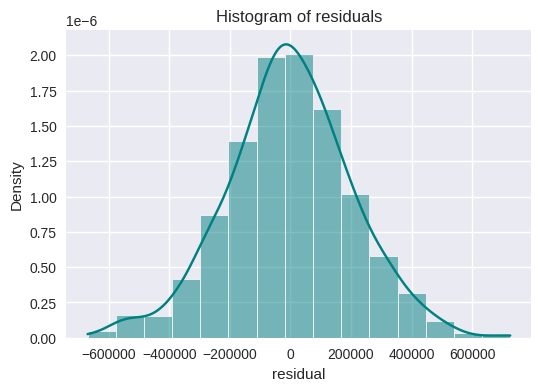

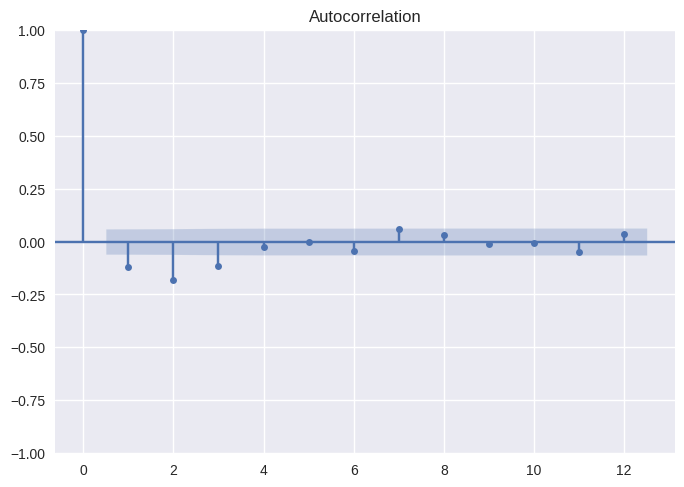

In [ ]:
plt.plot(model_ETS_diff.resid,'o-b');
plt.title('Residuals (Training)')

fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(x=model_ETS_diff.resid, stat='density', linewidth=0.5, kde=True,color='teal',bins=15)
ax.set(title='Histogram of residuals', xlabel='residual');

plot_acf(model_ETS_diff.resid,lags=12);

## ***Observation:*** The model does not look good as the residuals are still not uncorrelated. Thus, next try SARIMA and seasonaly adjusted ARIMA.

## **SARIMA**

Text(0.5, 0.98, 'ACF-PACF for wind generation')

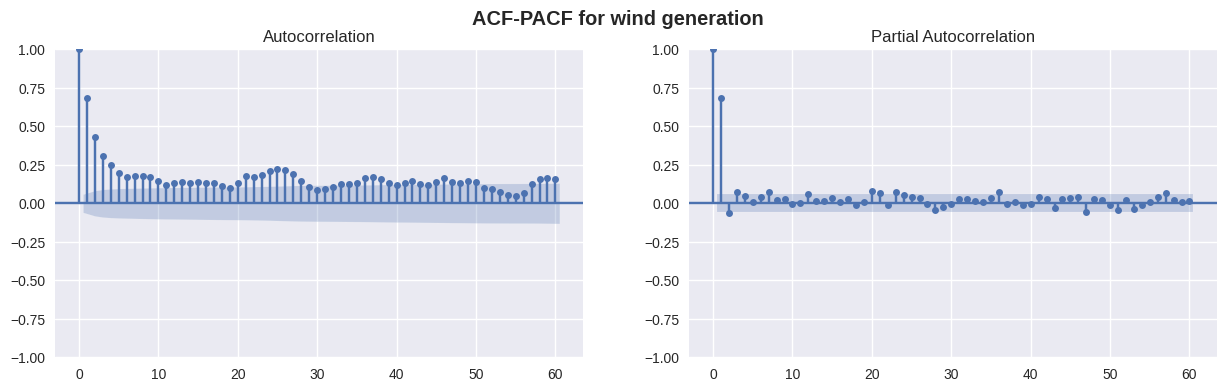

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
plot_acf(wind_power_df['wind_generation_actual'], lags=60, ax=ax[0])
plot_pacf(wind_power_df['wind_generation_actual'], lags=60, ax=ax[1])
plt.suptitle('ACF-PACF for wind generation', weight='bold')

## ***Observation:*** Since the seasonaliy is yearly, it is difficult to plot and predict p,q parameter values for both sesaonal and non seasonal. But non seasonal p component can be esimated as 1. Since it is difficult to manually estimate, use autoarima as follows.

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.6 MB/s eta 0:00:00


In [ ]:
# model_SARIMA = auto_arima(wind_power_df['wind_generation_actual'], start_p=0, start_q=0, d=0,
#                            max_p=5, max_q=5, m=365,
#                            start_P=0, start_Q=0,max_P = 5, max_Q = 5, D = 1, seasonal=True,
#                            trace=True, information_criterion='aic',
#                            error_action='ignore',
#                            suppress_warnings=True,
#                            stepwise=True)

In [ ]:
# print(model_SARIMA.summary())
# model_SARIMA.plot_diagnostics(figsize=(20,10));

## ***Remark:*** This crashes. So aggregrat data to weekly frequency.

In [75]:
wind_power_df_copy = wind_power_df.copy()

In [76]:
wind_power_df_copy = wind_power_df_copy.drop('Period_Y', axis=1)

In [ ]:
wind_power_df_copy = wind_power_df_copy.drop(['wind_capacity', 'temperature'], axis=1)

In [ ]:
# Resample to weekly data, summing up the values for the week
#weekly_data = wind_power_df_copy.resample('W').sum()

# the values for each week are very large, when sum(), leading to large values that might not represent what trying to model.

In [ ]:
# Resample to weekly data, take mean values for the week
weekly_data_wind = wind_power_df_copy.resample('W').mean()

In [ ]:
weekly_data_wind.head(5)

wind_generation_actual
date                              
2017-01-01           291760.000000
2017-01-08           331270.714286
2017-01-15           418425.000000
2017-01-22            94920.000000
2017-01-29           163572.571429

In [ ]:
wind_power_df.shape

(1094, 4)

In [ ]:
weekly_data_wind.shape

(158, 1)

In [ ]:
weekly_data_wind.index

DatetimeIndex(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
               '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
               '2017-02-26', '2017-03-05',
               ...
               '2019-11-03', '2019-11-10', '2019-11-17', '2019-11-24',
               '2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22',
               '2019-12-29', '2020-01-05'],
              dtype='datetime64[ns]', name='date', length=158, freq='W-SUN')

<Axes: title={'center': 'Weekly Aggregated Data'}, xlabel='date'>

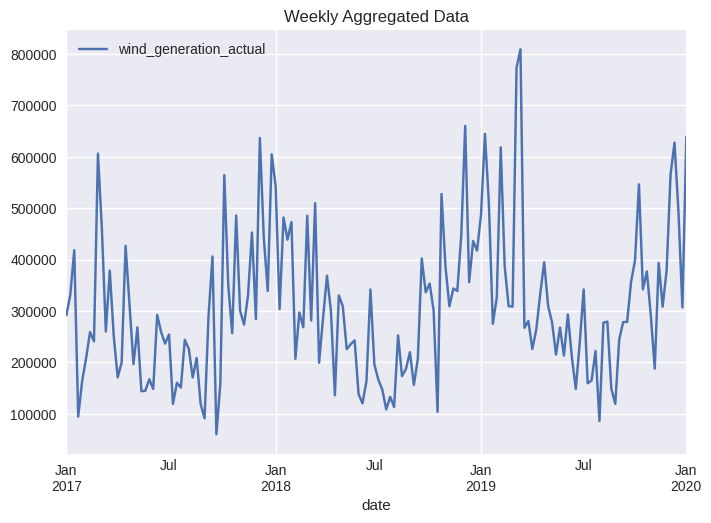

In [ ]:
weekly_data_wind.plot(title="Weekly Aggregated Data")

Text(0.5, 0.98, 'ACF-PACF for wind generation-weekly data')

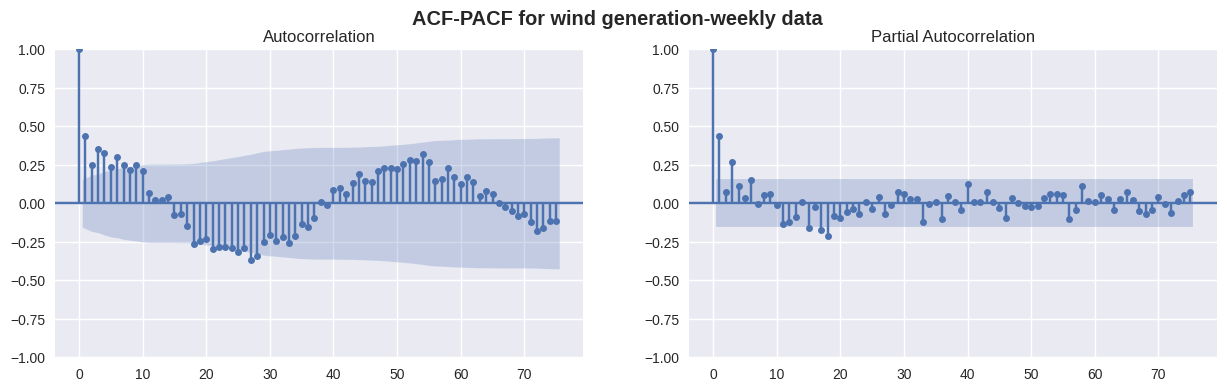

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
plot_acf(weekly_data_wind, lags=75, ax=ax[0])
plot_pacf(weekly_data_wind, lags=75, ax=ax[1])
plt.suptitle('ACF-PACF for wind generation-weekly data', weight='bold')

In [ ]:
# ADF and KPSS
adf_test_ = adfuller(weekly_data_wind,autolag='AIC')
kpss_test_ = kpss(weekly_data_wind, regression='c', nlags='auto', store=True)
kpss_test_trend_ = kpss(weekly_data_wind, regression='ct', nlags='auto', store=True)
print('ADF p-value: ', adf_test_[1])
print('KPSS p-value: ', kpss_test_[1])
print('KPSS_trend p-value: ', kpss_test_trend_[1])

ADF p-value:  0.2343232327316201
KPSS p-value:  0.1
KPSS_trend p-value:  0.1


<ipython-input-92-75b1e0bba071>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_ = kpss(weekly_data_wind, regression='c', nlags='auto', store=True)
<ipython-input-92-75b1e0bba071>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_trend_ = kpss(weekly_data_wind, regression='ct', nlags='auto', store=True)


## ***Observation:*** Not stationary, as the ADF p value is 0.2343 > 0.05, meaning accept the null hypothesis. So do first differencing to make stationary .
    H0: Not stationary.

In [ ]:
diff_data_W = weekly_data_wind.diff().dropna()

Text(0.5, 0.98, 'ACF-PACF for wind generation')

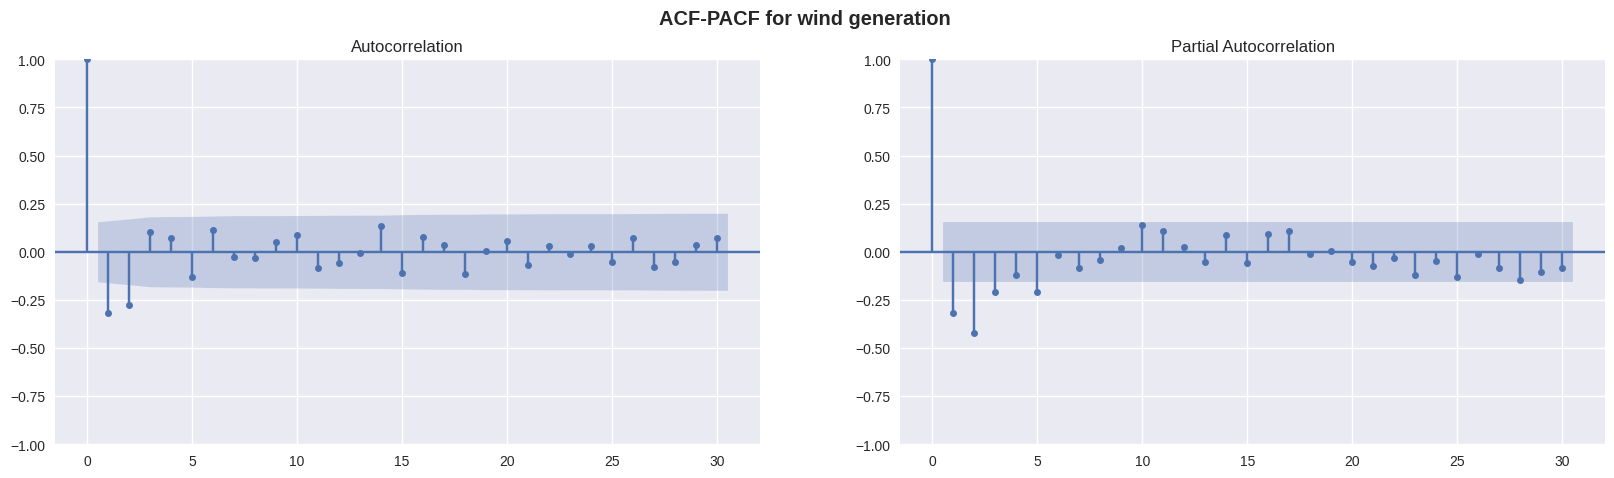

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(diff_data_W, lags=30, ax=ax[0])
plot_pacf(diff_data_W, lags=30, ax=ax[1])
plt.suptitle('ACF-PACF for wind generation', weight='bold')

In [ ]:
adf_test_ = adfuller(diff_data_W,autolag='AIC')
kpss_test_ = kpss(diff_data_W, regression='c', nlags='auto', store=True)
kpss_test_trend_ = kpss(diff_data_W, regression='ct', nlags='auto', store=True)
print('ADF p-value: ', adf_test_[1])
print('KPSS p-value: ', kpss_test_[1])
print('KPSS_trend p-value: ', kpss_test_trend_[1])

ADF p-value:  5.686987154566553e-16
KPSS p-value:  0.06526163486190922
KPSS_trend p-value:  0.01


<ipython-input-96-3565edee616b>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_trend_ = kpss(diff_data_W, regression='ct', nlags='auto', store=True)


## ***Observation:*** Still not stationary, as the KPSS_trend p value is 0.01 < 0.05, meaning reject the null hypothesis. So do sesaonal differencing to make stationary .
H0: Stationary.

In [ ]:
data_diff_seas = weekly_data_wind.diff(52).dropna()

In [ ]:
adf_test_ = adfuller(data_diff_seas,autolag='AIC')
kpss_test_ = kpss(data_diff_seas, regression='c', nlags='auto', store=True)
kpss_test_trend_ = kpss(data_diff_seas, regression='ct', nlags='auto', store=True)
print('ADF p-value: ', adf_test_[1])
print('KPSS p-value: ', kpss_test_[1])
print('KPSS_trend p-value: ', kpss_test_trend_[1])

ADF p-value:  7.698969339771319e-16
KPSS p-value:  0.1
KPSS_trend p-value:  0.1


<ipython-input-99-4b71039b1b5d>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_ = kpss(data_diff_seas, regression='c', nlags='auto', store=True)
<ipython-input-99-4b71039b1b5d>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_trend_ = kpss(data_diff_seas, regression='ct', nlags='auto', store=True)


Text(0.5, 0.98, 'ACF-PACF for wind generation')

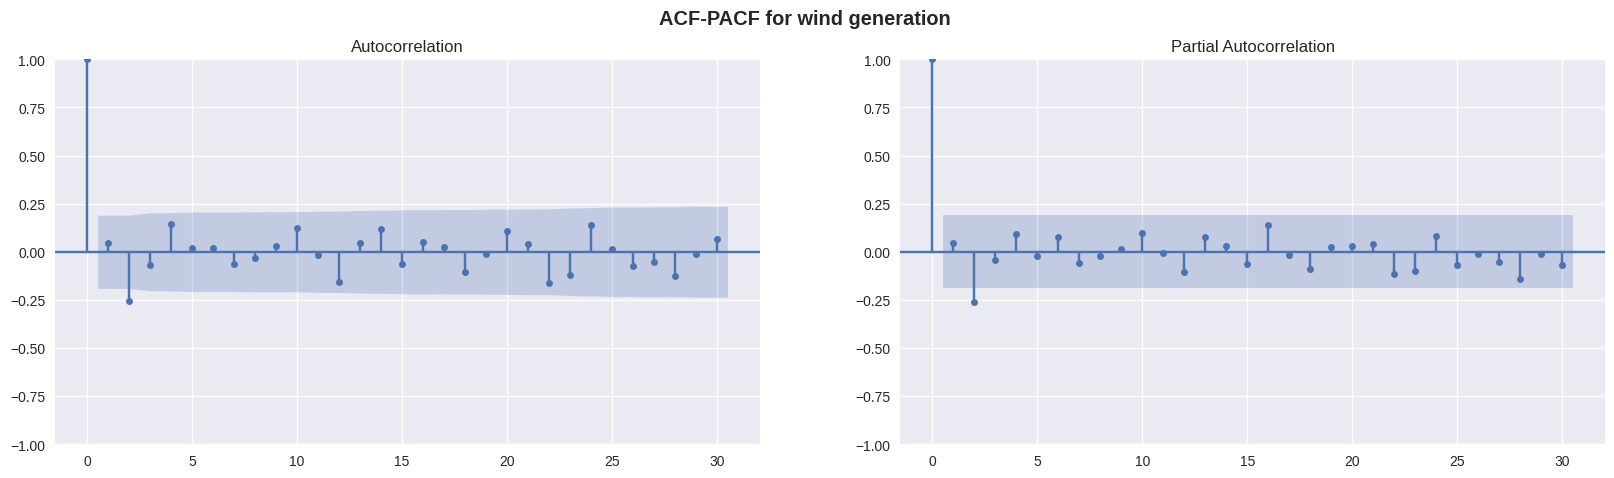

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(data_diff_seas, lags=30, ax=ax[0])
plot_pacf(data_diff_seas, lags=30, ax=ax[1])
plt.suptitle('ACF-PACF for wind generation', weight='bold')

## ***Observation:*** Stationary.

In [ ]:
train_w = diff_data_W.loc[:'2019-10-30']
test_w = diff_data_W.loc['2019-11-01':]

In [ ]:
test_w.shape

(10, 1)

In [ ]:
train_w.shape

(147, 1)

In [ ]:
# model_SARIMA_W = auto_arima(data_diff_seas, start_p=0, start_q=0, d=0,
#                            max_p=5, max_q=5, m=52,
#                            start_P=0, start_Q=0,max_P = 5, max_Q = 5, D = 1, seasonal=True,
#                            trace=True, information_criterion='aic',
#                            error_action='ignore',
#                            suppress_warnings=True,
#                            stepwise=False)

In [ ]:
#Since this crashes, choose the paramteres with minimum AIC and check.
# [p,d,q] = [0,0,0]
# [P,D,Q,S] = [1,1,1,52]
# model_SARIMA_W = SARIMAX(train_w,
#                        order=(p,d,q),
#                        seasonal_order=(P,D,Q,S), trend='c')
# result_SARIMA_W = model_SARIMA_W.fit()

# # Verify the residuals
# print(result_SARIMA_W.summary())
# result_SARIMA_W.plot_diagnostics(figsize=(20, 10));

In [ ]:
# print(model_SARIMA_W.summary())
# model_SARIMA_W.plot_diagnostics(figsize=(20,10));

## ***Remark:*** This also crashes. Since this keeps crashing, go for the next seasonality, that is monthly which was visible

In [ ]:
# model_SARIMA_M = auto_arima(wind_power_df['wind_generation_actual'], start_p=0, start_q=0, d=0,
#                            max_p=5, max_q=5, m=30,
#                            start_P=0, start_Q=0,max_P = 5, max_Q = 5, D = 1, seasonal=True,
#                            trace=True, information_criterion='aic',
#                            error_action='ignore',
#                            suppress_warnings=True,
#                            stepwise=False)

## ***Remark:*** Crashed.

## ***Remark:*** Try resampling to monthly frequency.

In [88]:
monthly_data_wind = wind_power_df_copy.resample('M').mean()

<ipython-input-88-cb996e291734>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data_wind = wind_power_df_copy.resample('M').mean()


In [ ]:
monthly_data_wind.head(5)

wind_generation_actual
date                              
2017-01-31           252004.774194
2017-02-28           353563.964286
2017-03-31           299794.258065
2017-04-30           271003.133333
2017-05-31           182148.935484

<Axes: xlabel='date'>

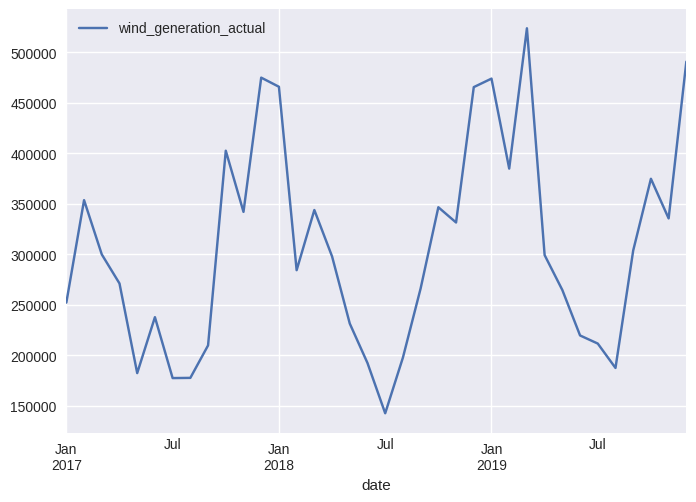

In [ ]:
monthly_data_wind.plot()

Frequency for the maximum value is:  0.08333333333333333
Period (months/cycle):  12.0


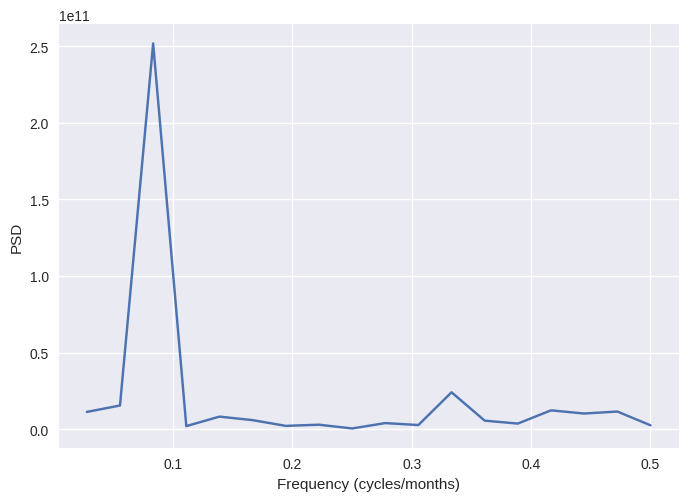

In [ ]:
from scipy.signal import periodogram
Fs=1

f_per, Pxx_per = periodogram(monthly_data_wind['wind_generation_actual'],Fs,detrend=False,window='boxcar',return_onesided=True,scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

plt.plot(f_per, Pxx_per)
plt.xlabel('Frequency (cycles/months)')
plt.ylabel('PSD');

temp = np.argmax(Pxx_per)
max_frequency = f_per[temp]
max_period = 1 / max_frequency

print('Frequency for the maximum value is: ', max_frequency)
print('Period (months/cycle): ', max_period)

## ***Observation:***The plot shows the yearly seasonality as expected and PSD confirms the yearly seasnality with 12 months cycle.

Text(0.5, 0.98, 'ACF-PACF for wind generation')

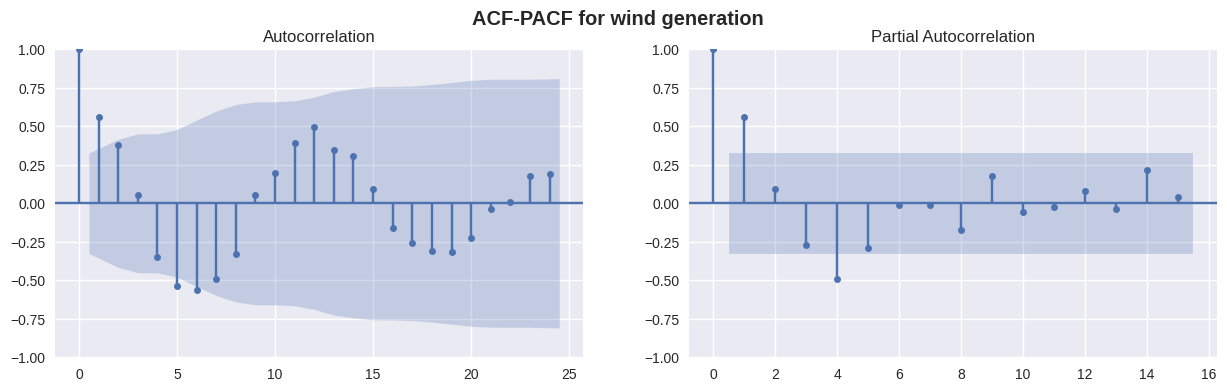

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
plot_acf(monthly_data_wind, lags=24, ax=ax[0])
plot_pacf(monthly_data_wind, lags=15, ax=ax[1])
plt.suptitle('ACF-PACF for wind generation', weight='bold')

In [ ]:
# ADF and KPSS
adf_test_ = adfuller(monthly_data_wind,autolag='AIC')
kpss_test_ = kpss(monthly_data_wind, regression='c', nlags='auto', store=True)
kpss_test_trend_ = kpss(monthly_data_wind, regression='ct', nlags='auto', store=True)
print('ADF p-value: ', adf_test_[1])
print('KPSS p-value: ', kpss_test_[1])
print('KPSS_trend p-value: ', kpss_test_trend_[1])

ADF p-value:  0.02157219678153532
KPSS p-value:  0.1
KPSS_trend p-value:  0.1


<ipython-input-112-dea6a62deeeb>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_ = kpss(monthly_data_wind, regression='c', nlags='auto', store=True)
<ipython-input-112-dea6a62deeeb>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_trend_ = kpss(monthly_data_wind, regression='ct', nlags='auto', store=True)


## ***Observation:***Since the test results are not clear and ACF plot does not look stationary, first apply SARIMA on data without differencing and the on differenced data.

## ***Remarks:*** Assume from the plots for non sesonality p=2 and q=1.

In [89]:
train_ = monthly_data_wind.loc[:'2019-07']
test_ = monthly_data_wind.loc['2019-07':]

In [ ]:
test_

wind_generation_actual
date                              
2019-07-31           211417.709677
2019-08-31           187239.741935
2019-09-30           303675.600000
2019-10-31           374772.290323
2019-11-30           335470.366667
2019-12-31           490874.433333

In [ ]:
model_SARIMA_M = auto_arima(train_, start_p=0, start_q=0, d=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, start_Q=0,max_P = 5, max_Q = 5, D = 1, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=482.426, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=479.055, Time=0.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=478.538, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=486.598, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=478.142, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=478.581, Time=0.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=479.544, Time=1.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=479.147, Time=0.36 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=478.924, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=480.764, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=480.971, Time=0.52 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=477.427, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,0)[12]             : AIC=479.224, Time=0.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12]             : AIC=479.253, Time=0.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,0,1)(0,1,0)[12]             : AIC=479.032, Time=0.05 sec
 ARIMA(0,0,2)(0,1,0)[12]             : AIC=479.279, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=479.590, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,0)[12]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(0,0,1)(0,1,0)[12]          
Total fit time: 5.570 seconds


                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                   31
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                -236.071
Date:                             Wed, 22 Jan 2025   AIC                            478.142
Time:                                     15:49:09   BIC                            480.976
Sample:                                 01-31-2017   HQIC                           478.622
                                      - 07-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.152e+04   1.77e+04      1.215      0.224   -1.32e+04    5.62e+04
ma.L1          0.4359      

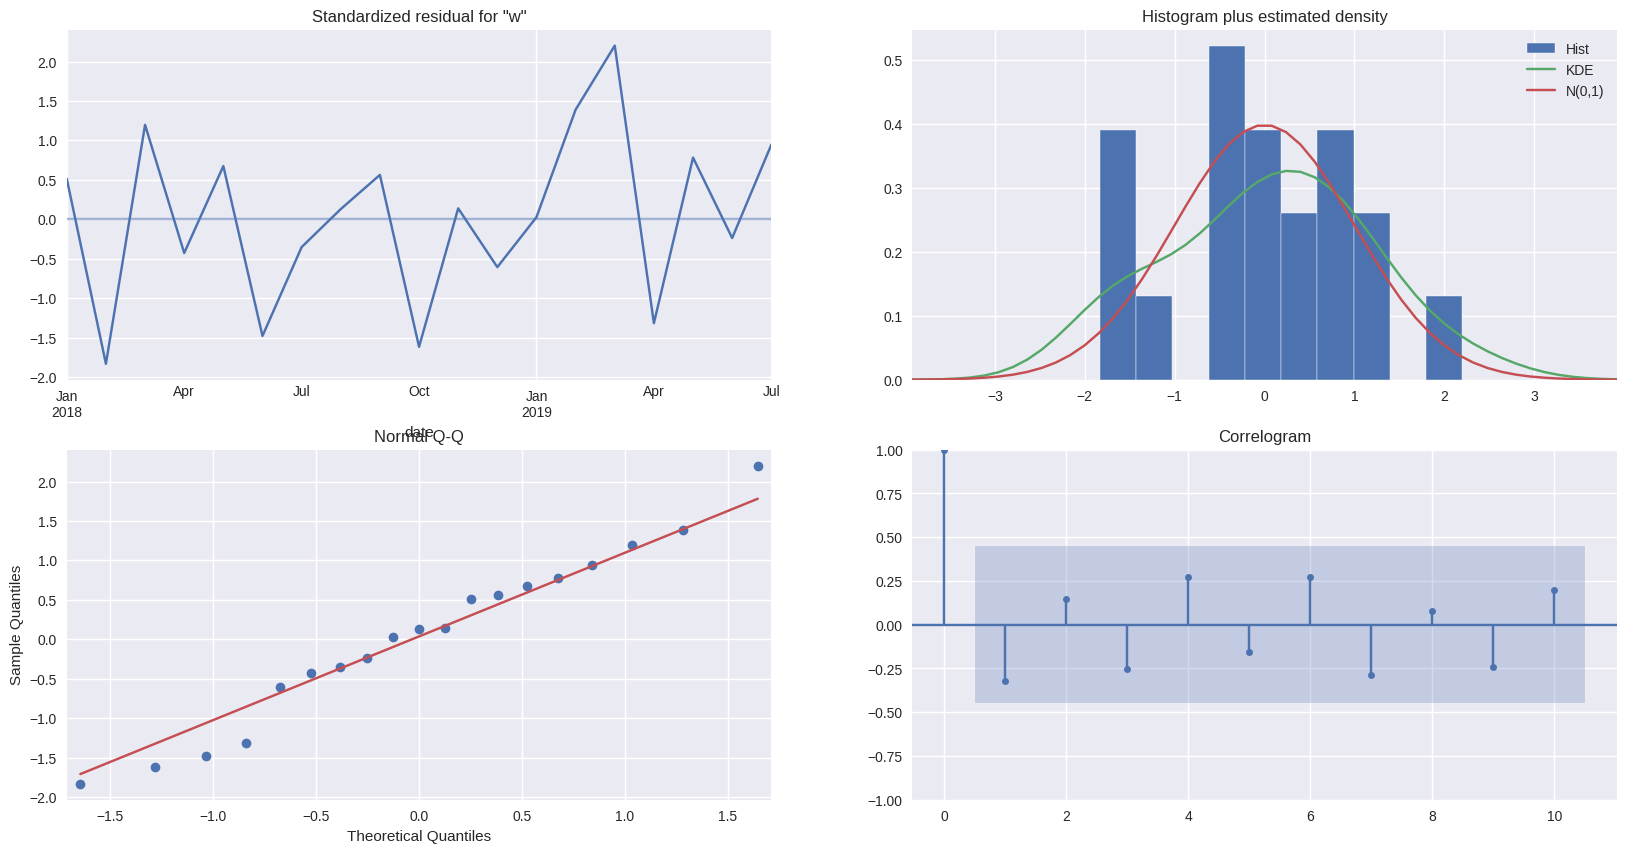

In [ ]:
[p,d,q] = [0,0,1]
[P,D,Q,S] = [0,1,0,12]
model_SARIMA_auto = SARIMAX(train_,
                       order=(p,d,q),
                       seasonal_order=(P,D,Q,S), trend='c')
result_SARIMA_auto = model_SARIMA_auto.fit()

# Verify the residuals
print(result_SARIMA_auto.summary())
result_SARIMA_auto.plot_diagnostics(figsize=(20, 10));

# **Observation:**
**1. Ljung-Box (Q)**

      Q=2.26
      Prob(Q):0.13

      H0: residuals are uncorrelated.

Prob(Q)>0.05: fail to reject the null hypothesis, indicating that the residuals do not exhibit significant autocorrelation.
Good outcome: The model captures the temporal structure well.

**2. Jarque-Bera (JB)**

     JB=0.33
     Prob(JB):0.85

     H0: residuals follow a normal distribution.

Prob(JB)>0.05 suggests the residuals are normally distributed.
Good outcome: This is favorable for statistical inference, especially if normality is an important assumption.

**3. Heteroskedasticity (H)**

    H=1.28
    Prob(H):0.77

    H0: residuals have constant variance (homoskedasticity).

Prob(H)>0.05 indicates no evidence of heteroskedasticity.
Good outcome: Residuals have consistent variance.

**4. Skewness and Kurtosis**

    Skewness: 0.07
Skewness close to 0 indicates the residuals are symmetric.
Good outcome: No significant skewness detected.

    Kurtosis: 2.37
Kurtosis close to 3 is expected for a normal distribution.


## **Conclusion:**This is a good model based on the diagnostic tests:

    The residuals are uncorrelated (Ljung-Box test passed).
    The residuals are normally distributed (Jarque-Bera test passed).
    The residuals have constant variance (Heteroskedasticity test passed).
    Residuals show no significant skewness or extreme kurtosis.

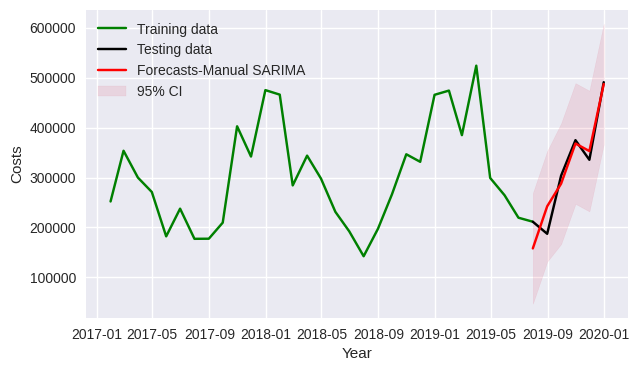

In [ ]:
# Forecasting with Manual SARIMA model - Test set
forecasts = result_SARIMA_auto.get_prediction(start=test_.index[0], end=test_.index[-1])
df_manual = forecasts.summary_frame()

plt.figure(figsize=(7, 4))
plt.plot(train_, color='green',label='Training data')
plt.plot(test_, color='black', label='Testing data')
plt.plot(df_manual['mean'], color='red', label='Forecasts-Manual SARIMA')
plt.fill_between(df_manual.index, df_manual['mean_ci_lower'], df_manual['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Costs')
plt.legend();

In [ ]:
# Model performance
print('Auto SARIMA model')
print('MAE :', mean_absolute_error(test_,df_manual['mean']))
print('RMSE:', root_mean_squared_error(test_,df_manual['mean']))
print('MAPE :', 100*mean_absolute_percentage_error(test_,df_manual['mean']))

Auto SARIMA model
MAE : 25421.883568700574
RMSE: 32950.27095553153
MAPE : 11.292913519941024


## ***Observation:*** This model performs well.

With a standard deviation of **205,728.86** in actual wind generation, the model's errors (MAE and RMSE) are much smaller in comparison, indicating it handles variability reasonably well.
Outliers:

The maximum wind generation is **998,899**, much higher than the mean. These extreme values might disproportionately influence the RMSE. However, the MAE (which is less sensitive to outliers) still suggests decent accuracy.

**Conclusion**
Good Performance: The model performs well, with MAPE within acceptable limits and error metrics proportionate to the scale of the data.



## ***Remark:*** As an extra step check SARIMA on differnced data.

In [ ]:
diff_M = monthly_data_wind.diff().dropna()

Text(0.5, 0.98, 'ACF-PACF for wind generation')

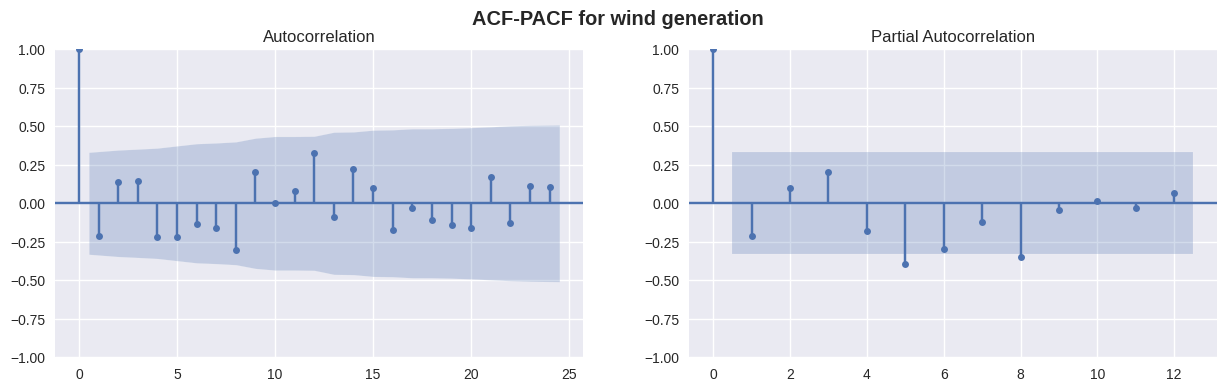

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
plot_acf(diff_M, lags=24, ax=ax[0])
plot_pacf(diff_M, lags=12, ax=ax[1])
plt.suptitle('ACF-PACF for wind generation', weight='bold')

In [ ]:
train_diff = diff_M.loc[:'2019-07']
test__diff = diff_M.loc['2019-07':]

In [ ]:
model_SARIMA_M_diff = auto_arima(train_diff, start_p=0, start_q=0, d=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, start_Q=0,max_P = 5, max_Q = 5, D = 1, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=468.615, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=467.947, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=469.542, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=475.021, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=1.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=468.841, Time=0.89 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=467.244, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=469.235, Time=0.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=469.232, Time=0.42 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=467.309, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=471.231, Time=1.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=inf, Time=3.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=inf, Time=6.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,0)[12]             : AIC=465.070, Time=0.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,0)[12]             : AIC=467.390, Time=1.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,1)[12]             : AIC=467.237, Time=0.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,1)[12]             : AIC=465.325, Time=0.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,1)[12]             : AIC=469.237, Time=0.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12]             : AIC=465.368, Time=0.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,0)[12]             : AIC=453.477, Time=0.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,0)[12]             : AIC=452.476, Time=0.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12]             : AIC=453.540, Time=0.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,1)[12]             : AIC=455.389, Time=1.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[12]             : AIC=inf, Time=0.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,0)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=472.404, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,0)[12]             : AIC=inf, Time=0.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.25 sec

Best model:  ARIMA(0,0,1)(0,1,0)[12]          
Total fit time: 22.437 seconds


                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                   30
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                -224.231
Date:                             Wed, 22 Jan 2025   AIC                            454.462
Time:                                     15:49:01   BIC                            457.133
Sample:                                 02-28-2017   HQIC                           454.830
                                      - 07-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -60.8434   1793.806     -0.034      0.973   -3576.639    3454.952
ma.L1         -1.0000      

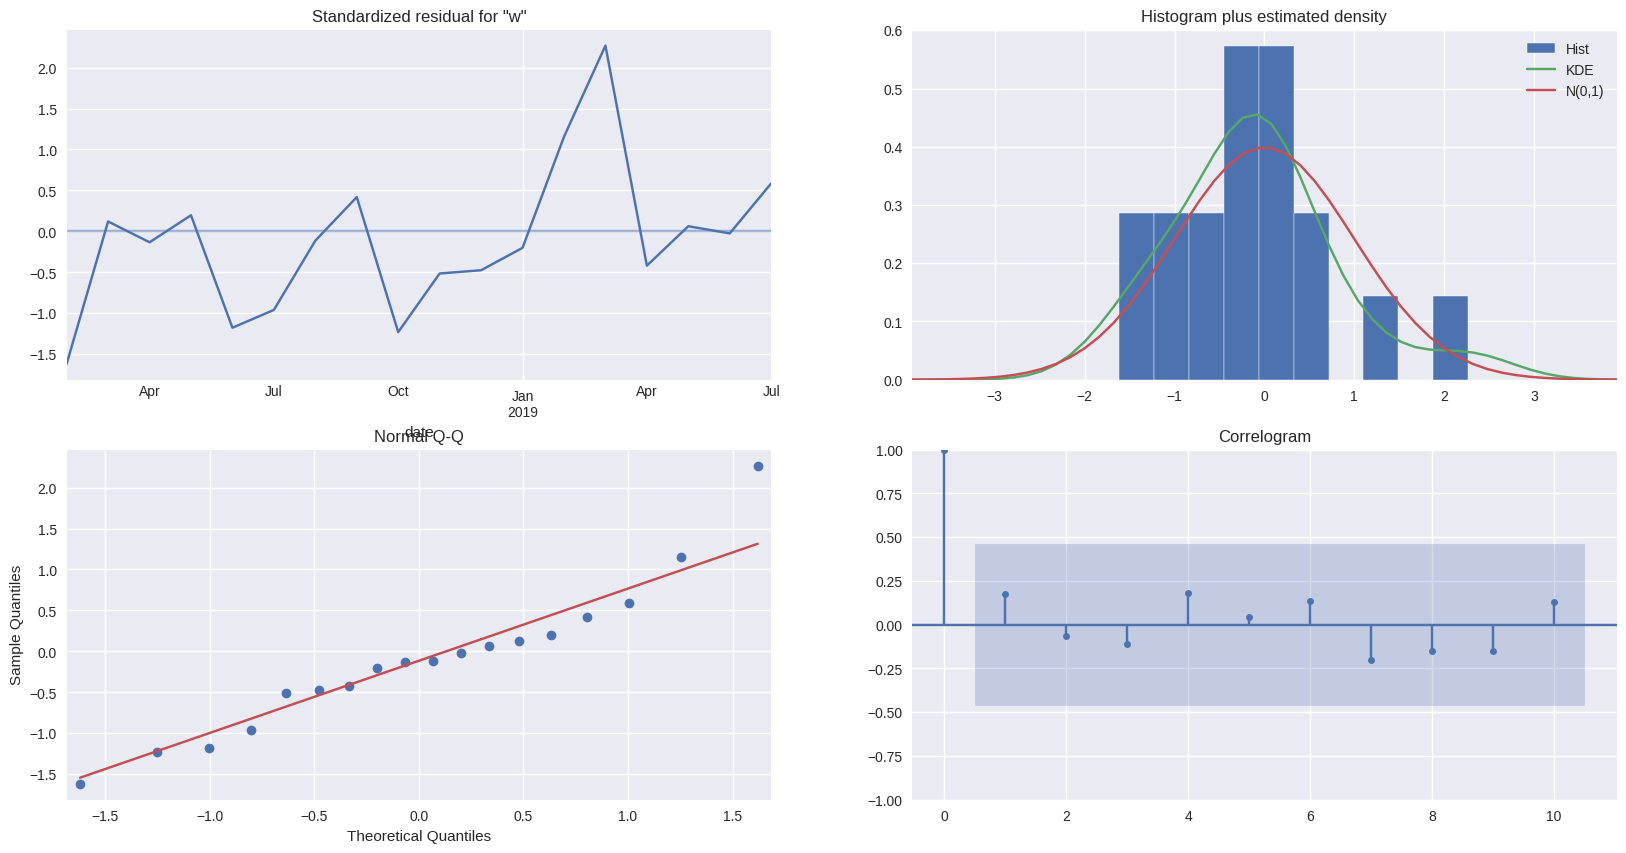

In [ ]:
[p,d,q] = [0,0,1]
[P,D,Q,S] = [0,1,0,12]
model_SARIMA_auto_diff = SARIMAX(train_diff,
                       order=(p,d,q),
                       seasonal_order=(P,D,Q,S), trend='c')
result_SARIMA_auto_diff = model_SARIMA_auto_diff.fit()

print(result_SARIMA_auto_diff.summary())
result_SARIMA_auto_diff.plot_diagnostics(figsize=(20, 10));

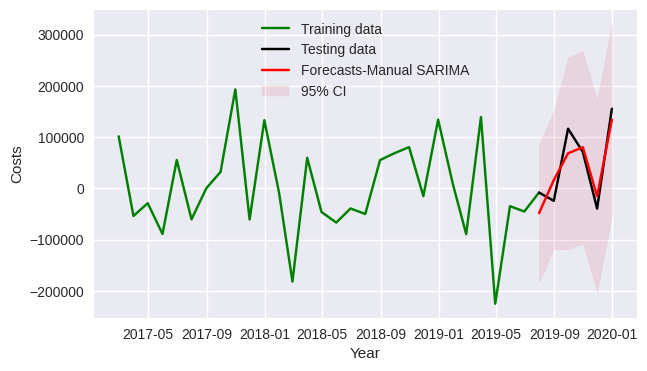

In [ ]:
# Forecasting with Manual SARIMA model - Test set
forecasts = result_SARIMA_auto_diff.get_prediction(start=test__diff.index[0], end=test__diff.index[-1])
df_auto = forecasts.summary_frame()

plt.figure(figsize=(7, 4))
plt.plot(train_diff, color='green',label='Training data')
plt.plot(test__diff, color='black', label='Testing data')
plt.plot(df_auto['mean'], color='red', label='Forecasts-Manual SARIMA')
plt.fill_between(df_auto.index, df_auto['mean_ci_lower'], df_auto['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Costs')
plt.legend();

In [ ]:
# Model performance
print('Auto SARIMA model')
print('MAE :', mean_absolute_error(test__diff,df_auto['mean']))
print('RMSE:', root_mean_squared_error(test__diff,df_auto['mean']))
print('MAPE :', 100*mean_absolute_percentage_error(test__diff,df_auto['mean']))

Auto SARIMA model
MAE : 30549.0472277636
RMSE: 33344.19079298908
MAPE : 132.77321260354384


In [ ]:
#reverse diff

In [ ]:
forecast_inversed = df_auto['mean'] + train_diff.iloc[-1]

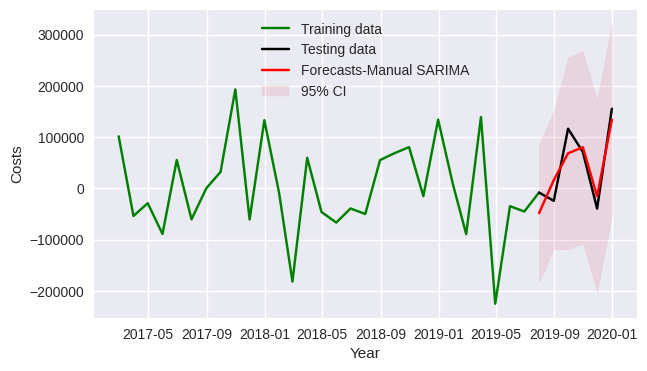

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(train_diff.index, train_diff['wind_generation_actual'], color='green', label='Training data')  # Make sure to reference the actual data values
plt.plot(test__diff.index, test__diff['wind_generation_actual'], color='black', label='Testing data')  # Same for test_
plt.plot(df_auto.index, df_auto['mean'], color='red', label='Forecasts-Manual SARIMA')
plt.fill_between(df_auto.index, df_auto['mean_ci_lower'], df_auto['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Costs')
plt.legend()
plt.show()


## ***Remark:*** The model is stationary, yet perofromance is better in non differenced data. So this is an extra step for checking.

Ljung-Box (L1) Q-statistic = 0.65, p-value = 0.42
Since p > 0.05, do not reject the null hypothesis, meaning no significant autocorrelation in residuals.The residuals seem independent.

Jarque-Bera Test (Normality of Residuals)
JB Statistic = 2.51, p-value = 0.29
Since p > 0.05, do not reject the null hypothesis, meaning residuals are approximately normal.

Heteroskedasticity Test (Variance Stability)
H = 1.41, p-value = 0.69
Since p > 0.05, do not reject the null hypothesis, meaning variance is stable over time (no heteroskedasticity).



# **Seasonally Adjusted ARIMA**

In [ ]:
seasonal_component = decompose_data_add_365.seasonal

In [ ]:
seasonal_adjusted = wind_power_df['wind_generation_actual']-seasonal_component

In [ ]:
adf_test = adfuller(seasonal_adjusted,autolag='AIC')
kpss_test = kpss(seasonal_adjusted, regression='ct', nlags='auto', store=True)
print('ADF p-value: ', adf_test[1])
print('KPSS p-value: ', kpss_test[1])

ADF p-value:  1.555148575741442e-29
KPSS p-value:  0.1


<ipython-input-134-4c61b97d09f4>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(seasonal_adjusted, regression='ct', nlags='auto', store=True)


Text(0.5, 0.98, 'ACF-PACF for wind power-ARIMA) process')

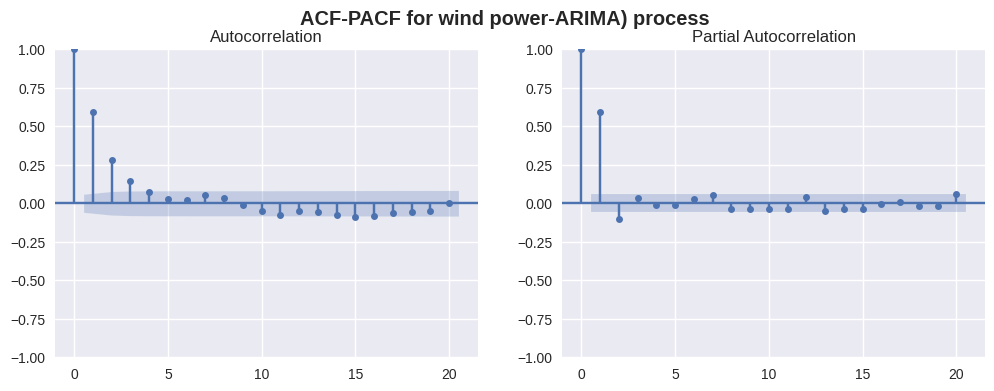

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
plot_acf(seasonal_adjusted, lags=20, ax=ax[0])
plot_pacf(seasonal_adjusted, lags=20, ax=ax[1])
plt.suptitle('ACF-PACF for wind power-ARIMA) process', weight='bold')

## ***Observation:*** Stationary. Assume AR(2) since in ACF plot it has a slight decreasing.


In [ ]:
train_ARIMA = seasonal_adjusted.loc[:'2019-11-30']
test_ARIMA = seasonal_adjusted.loc['2019-12-01':]

In [ ]:
arima_model =  auto_arima(train_ARIMA,start_p=0, d=0, start_q=0,
                          max_p=6, max_q=6, m=0, seasonal=False,
                          error_action='warn', with_intercept = True,trace = True,
                          supress_warnings=True, stepwise = False,
                          random_state=20,information_criterion='aic')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=28536.951, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=28169.096, Time=0.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=28097.633, Time=0.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=28087.084, Time=1.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=28080.288, Time=1.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=28079.593, Time=1.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28086.482, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=28076.492, Time=0.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=28076.768, Time=1.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=28078.212, Time=1.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=28081.074, Time=3.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=28074.670, Time=1.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=28076.819, Time=0.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=28078.161, Time=1.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=28080.321, Time=2.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=28075.560, Time=0.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=28077.553, Time=1.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=28080.080, Time=6.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=28077.546, Time=2.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=28079.605, Time=4.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=28079.440, Time=2.29 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 36.248 seconds


In [ ]:
mod_AR2 = ARIMA(train_ARIMA, order=(2,0,0), trend='c').fit()

print(mod_AR2.summary())
print('Estimated Coefficients:', mod_AR2.params)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1064
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -14033.324
Date:                Wed, 22 Jan 2025   AIC                          28074.648
Time:                        15:49:48   BIC                          28094.527
Sample:                    01-01-2017   HQIC                         28082.180
                         - 11-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.051e+05   8579.408     35.562      0.000    2.88e+05    3.22e+05
ar.L1          0.6574      0.029     22.846      0.000       0.601       0.714
ar.L2         -0.1140      0.026     -4.368      0.0

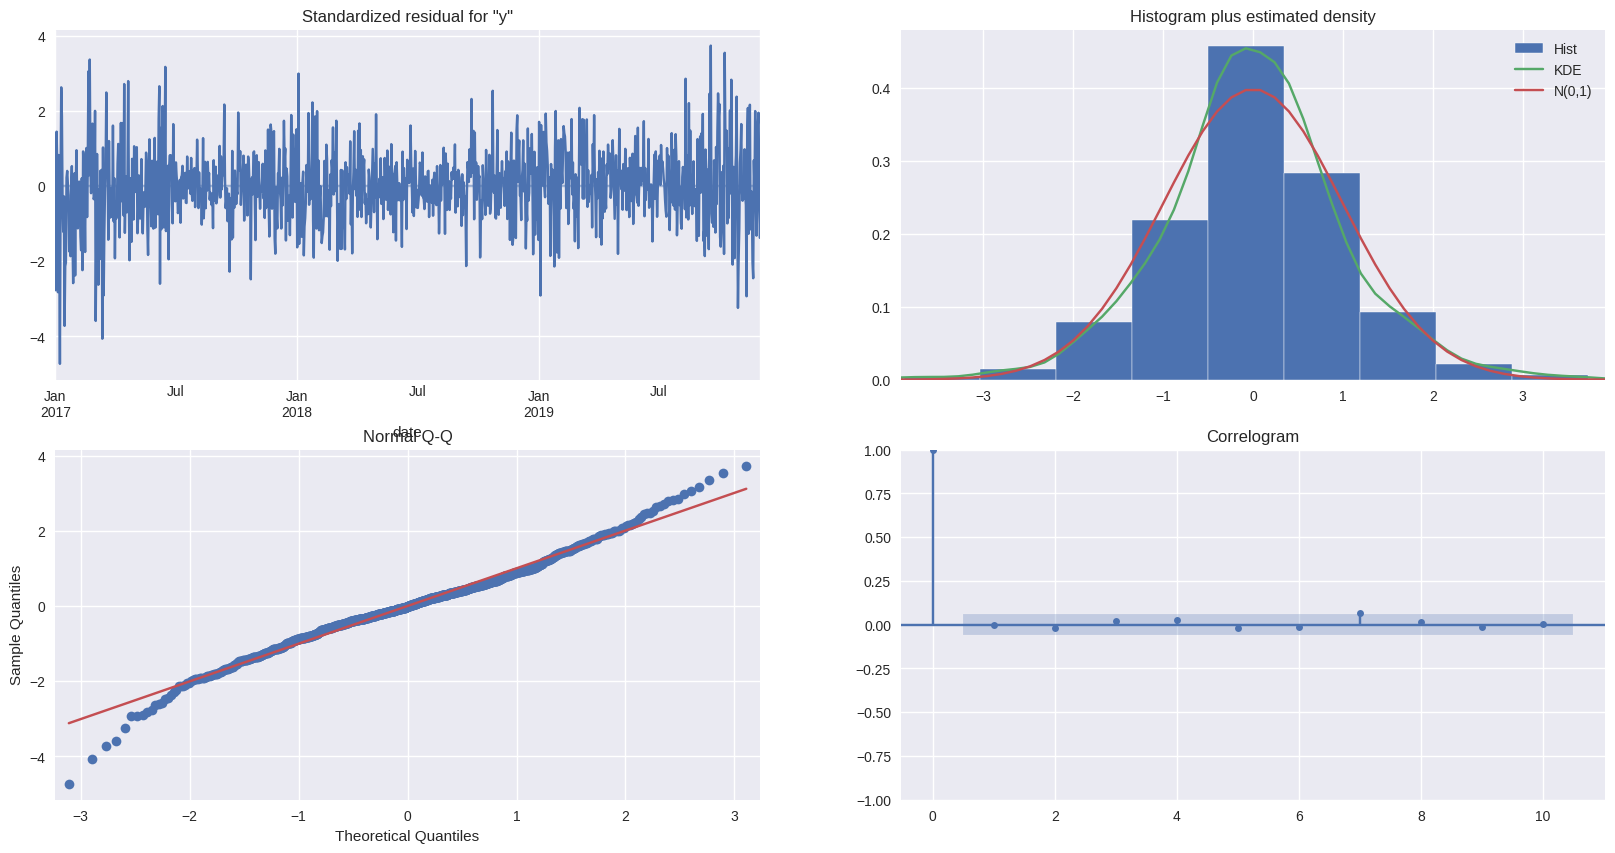

In [ ]:
mod_AR2.plot_diagnostics(figsize=(20, 10));

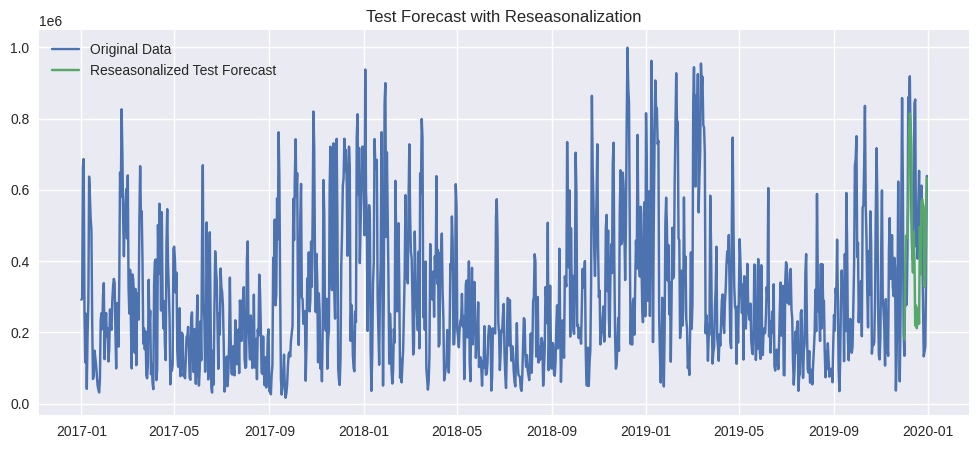

In [ ]:
forecasts_ARIMA = mod_AR2.forecast(steps=len(test_ARIMA))

test_forecast_index = forecasts_ARIMA.index

test_seasonal = seasonal_component[test_forecast_index] # Seasonal values for test period
reseasonalized_test_forecast = forecasts_ARIMA + test_seasonal

plt.figure(figsize=(12, 5))
plt.plot(wind_power_df['wind_generation_actual'], label="Original Data")
plt.plot(test_forecast_index, reseasonalized_test_forecast, label="Reseasonalized Test Forecast")
plt.title("Test Forecast with Reseasonalization")
plt.legend()
plt.show()

In [ ]:
print('Seasonally Adjusted ARIMA model')
print('MAE :', mean_absolute_error(test_ARIMA,forecasts_ARIMA))
print('RMSE:', root_mean_squared_error(test_ARIMA,forecasts_ARIMA))
print('MAPE :', 100*mean_absolute_percentage_error(test_ARIMA,forecasts_ARIMA))

Seasonally Adjusted ARIMA model
MAE : 176865.3072483205
RMSE: 233882.76667648734
MAPE : 91.48259707576123


## ***Observation:*** The model is good but Jarque-Bera test suggests non-normality. (H0: The data follows a normal distribution.) However the performance also, SARIMA performs better than this model.

# **SARIMAX**

## **Remark:** Tried with both temperature and wind_capacity, but wind capacity was not significant according to results, so removed

In [ ]:
model_SARIMAX = SARIMAX(train_['wind_generation_actual'],
                         order=(0,0,1),
                         seasonal_order=(0,1,0,12),
                         exog=train_['temperature'])
result_SARIMAX = model_SARIMAX.fit()
print(result_SARIMAX.summary())


                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                   31
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                -235.572
Date:                             Wed, 29 Jan 2025   AIC                            477.143
Time:                                     21:36:00   BIC                            479.977
Sample:                                 01-31-2017   HQIC                           477.623
                                      - 07-31-2019                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature  1.336e+04   4207.500      3.175      0.001    5114.020    2.16e+04
ma.L1           0.2098  

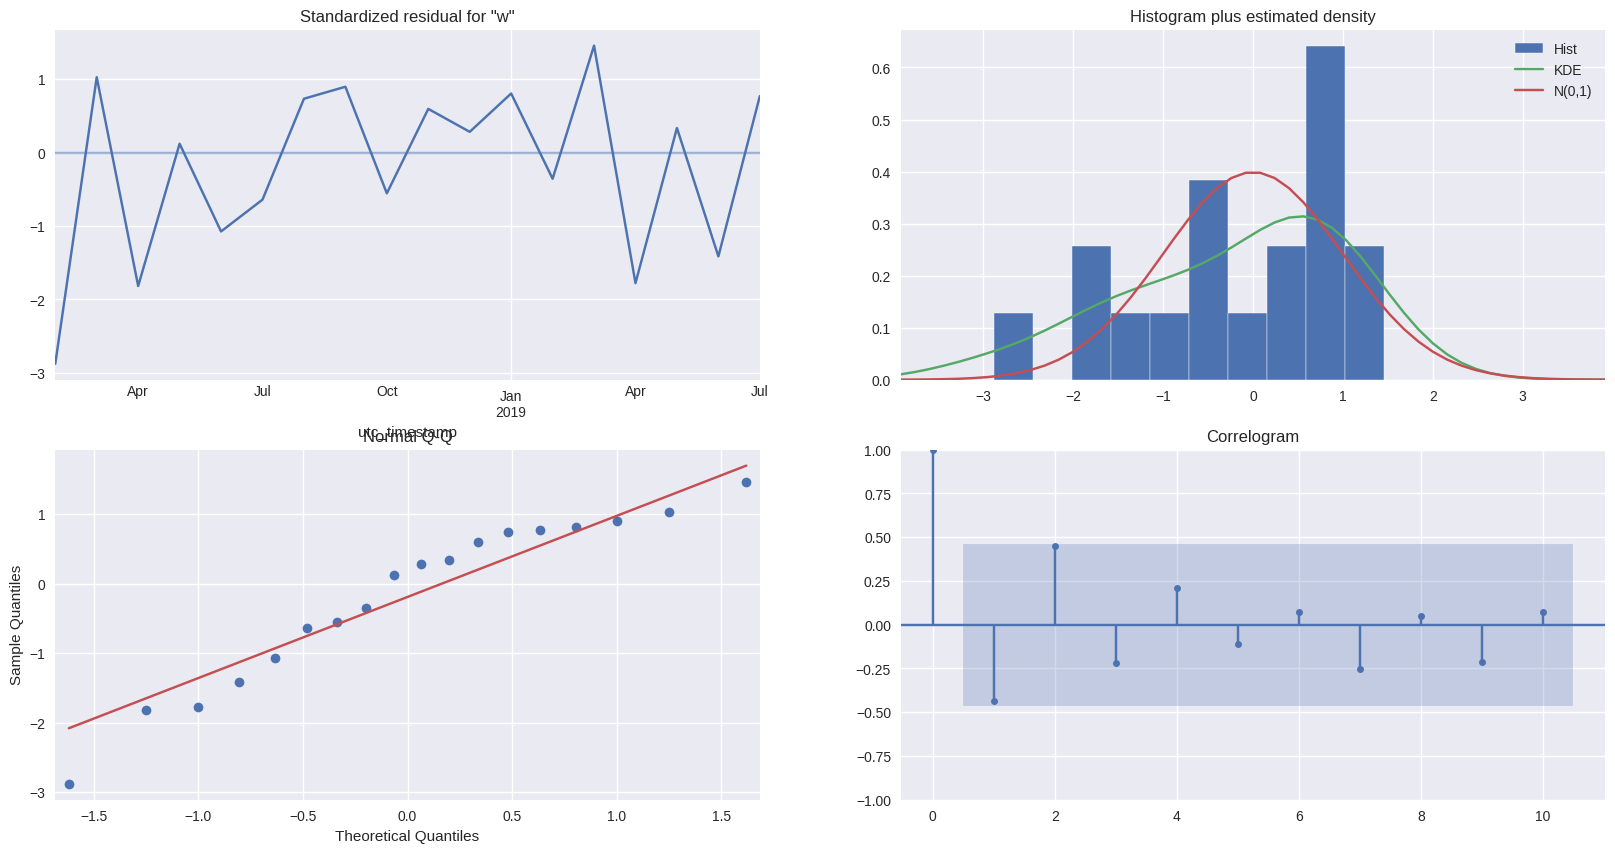

In [ ]:
result_SARIMAX.plot_diagnostics(figsize=(20, 10));

## ***Observation:***
**Ljung-Box (Q):**
p-value above 0.05 (0.25 here) suggests that there is no significant autocorrelation in the residuals.

**Jarque-Bera (JB):**
Tests for normality in the residuals. A p-value above 0.05 (0.57 here) suggests the residuals are normally distributed.

**Heteroskedasticity (H):** This test checks for variance instability in the residuals. A p-value of 0.69 indicates no significant heteroskedasticity.

## **Conclusion:** Model is good!

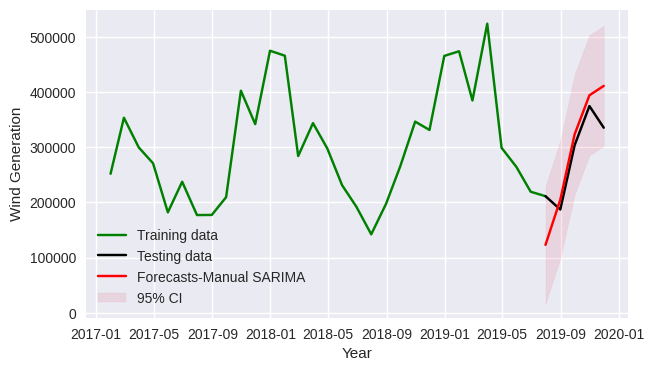

In [ ]:
future_exog = test_['temperature'].values.reshape(-1, 1)
forecast = result_SARIMAX.get_prediction(start=test_.index[0], end=test_.index[-1], exog=future_exog[0:-1])

df_manual = forecast.summary_frame()

plt.figure(figsize=(7, 4))
plt.plot(train_['wind_generation_actual'], color='green', label='Training data')
plt.plot(test_['wind_generation_actual'], color='black', label='Testing data')
plt.plot(df_manual['mean'], color='red', label='Forecasts-Manual SARIMA')
plt.fill_between(df_manual.index, df_manual['mean_ci_lower'], df_manual['mean_ci_upper'], alpha=0.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Wind Generation')
plt.legend()

In [ ]:
y_true = test_['wind_generation_actual']
y_pred = df_manual['mean']

print('MAE :', mean_absolute_error(y_true, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_true, y_pred)))
print('MAPE :', 100 * mean_absolute_percentage_error(y_true, y_pred))


MAE : 44241.372434111996
RMSE: 54085.85043839631
MAPE : 17.118916019940976


## ***Observation:***  Performs better than seasonaly adjusted ARIMA, ETS and Seasonal Naive, but still SARIMA performs better.

# **The Conclusion**
## *AS a conclusion, SARIMA performs better than Seasonal Naive, ETS, seasonally adjusted ARIMA and SARIMAX models.*

## So the forcasted values from SARIMA can be displayed as follows.

In [ ]:
forecast = result_SARIMA_auto.get_forecast(steps=len(test_))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

forecast_table = pd.DataFrame({
    'Date': test_.index,
    'Actual': test_['wind_generation_actual'].values,
    'Forecast': forecast_values.values,
    'Lower CI': confidence_intervals.iloc[:, 0].values,
    'Upper CI': confidence_intervals.iloc[:, 1].values
})

print(forecast_table.to_string(index=False))


                     Date        Actual      Forecast      Lower CI      Upper CI
2019-07-31 00:00:00+00:00 211417.709677 242341.906801 131583.398646 353100.414955
2019-08-31 00:00:00+00:00 187239.741935 287587.036569 166761.581704 408412.491434
2019-09-30 00:00:00+00:00 303675.600000 368071.553773 247246.098908 488897.008638
2019-10-31 00:00:00+00:00 374772.290323 352948.403236 232122.948370 473773.858101
2019-11-30 00:00:00+00:00 335470.366667 487144.231193 366318.776327 607969.686058
2019-12-31 00:00:00+00:00 490874.433333 495570.521515 374745.066650 616395.976380


# **Linear Regression**

## **Remark:** At first when check for correlations, even they are no strong correlations, the p-value suggested a significance, thus check on linear regression as follows.

In [28]:
y = wind_power_df['wind_generation_actual'].values
N = len(y)

X = np.array(wind_power_df[['wind_capacity','temperature']])
X = X.reshape((N,2))

print('X dimension',X.shape)
print('y dimension',y.shape)

X dimension (1094, 2)
y dimension (1094,)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     84.03
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           1.14e-34
Time:                        16:31:57   Log-Likelihood:                -14858.
No. Observations:                1094   AIC:                         2.972e+04
Df Residuals:                    1091   BIC:                         2.974e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.053e+04   6.08e+04      0.666      0.5

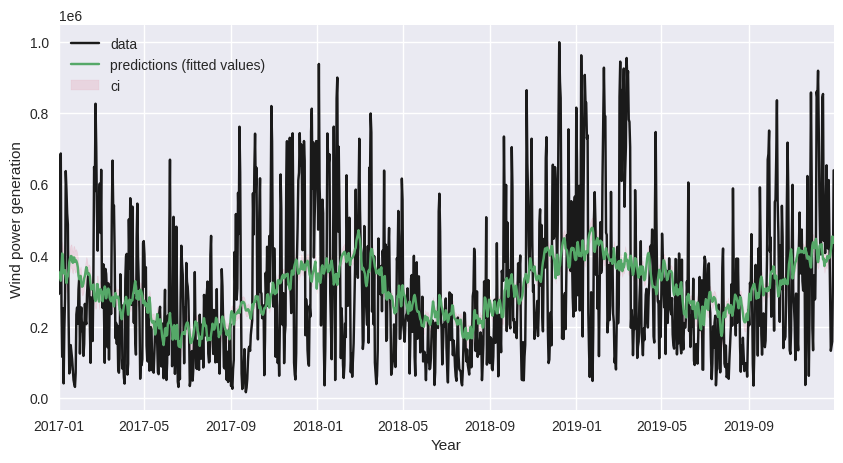

In [29]:
X_add = sm.add_constant(X)
results = sm.OLS(y, X_add).fit()
print(results.summary())

predictions = results.get_prediction(X_add)
df_predictions = predictions.summary_frame()

fig = plt.figure(figsize=(10, 5))
plt.plot(wind_power_df.index, y,'k-',label='data')
plt.plot(wind_power_df.index, df_predictions['mean'],'g-',label='predictions (fitted values)')
plt.fill_between(wind_power_df.index, df_predictions.mean_ci_lower, df_predictions.mean_ci_upper, alpha=.1, color='crimson',label='ci')
plt.legend(loc='best')
plt.xlim([wind_power_df.index[0],wind_power_df.index[-1]])
plt.xlabel('Year')
plt.ylabel('Wind power generation ')

print('RMSE value is: ', np.sqrt(mean_squared_error(y, df_predictions['mean'])))
print('MAPE value is: ', 100*mean_absolute_percentage_error(y, df_predictions['mean']))

# ***Observation:***

**Coefficients:**

x1 and x2 have statistically significant coefficients (P-values < 0.05), indicating that these variables are important predictors in the model.

**Goodness of Fit:**

The RMSE (191,418.81) and MAE (150,926.83) values are quite high, indicating that the model might not be performing well in terms of prediction accuracy.

**Residual Analysis:**

Durbin-Watson (DW) statistic: A value of 0.758 suggests some positive autocorrelation in the residuals.

Jarque-Bera (JB) test: The extremely small p-value (4.56e-26) indicates that the residuals are not normally distributed.

**Conclusion:**

While the model appears to have significant predictors (x1 and x2) and has reasonable explanatory power for those predictors, there are several concerns:

    High RMSE and MAE suggest poor predictive performance.
    The autocorrelation in residuals indicates that the model might not be fully capturing temporal dependencies, so the predictions could be less accurate.
    Non-normal residuals (based on the Jarque-Bera test) suggest the model's assumptions might not be fully satisfied, which could affect inference.

# **Additional**

## **Remark:**Regression check adding month as dummy variable to use as a predictor with teemperature.

In [ ]:
# Prepare dummy variables for months
X_1 = pd.DataFrame(data=pd.get_dummies(wind_power_df.index.month, drop_first=True, prefix='month'))
X_1.index = wind_power_df.index
X_1.head(7)

month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
date                                                                        
2017-01-01    False    False    False    False    False    False    False   
2017-01-02    False    False    False    False    False    False    False   
2017-01-03    False    False    False    False    False    False    False   
2017-01-04    False    False    False    False    False    False    False   
2017-01-05    False    False    False    False    False    False    False   
2017-01-06    False    False    False    False    False    False    False   
2017-01-07    False    False    False    False    False    False    False   

            month_9  month_10  month_11  month_12  
date                                               
2017-01-01    False     False     False     False  
2017-01-02    False     False     False     False  
2017-01-03    False     False     False     False  
2017-01-04    False     False     False     False  
2017-01-05    False     False     False     False  
2017-01-06    False     False     False     False  
2017-01-07    False     False     False     False

In [ ]:
# Prepare data
y = wind_power_df['wind_generation_actual'].values.reshape(len(wind_power_df),1)
X = np.array(pd.concat([wind_power_df['temperature'],X_1.loc[:,'month_2':'month_12']],axis=1))
print('X dim:', X.shape)
print('y dim:', y.shape)

X dim: (1094, 12)
y dim: (1094, 1)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     22.78
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           1.65e-45
Time:                        16:30:10   Log-Likelihood:                -14813.
No. Observations:                1094   AIC:                         2.965e+04
Df Residuals:                    1081   BIC:                         2.972e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.976e+05   1.92e+04     20.747      0.0

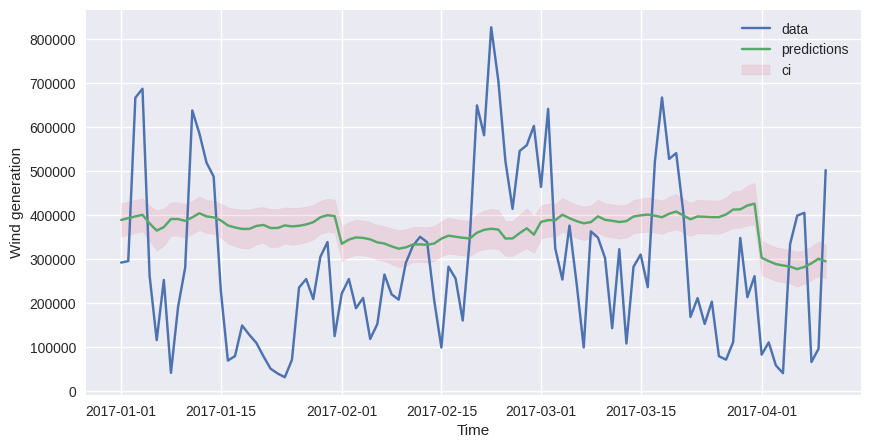

In [ ]:
X_d = sm.add_constant(X.astype(float))
results = sm.OLS(y, X_d).fit()
print(results.summary())

predictions = results.get_prediction(X_d)
df_predictions = predictions.summary_frame()

fig = plt.figure(figsize=(10, 5))
plt.plot(wind_power_df.index[:100], y[:100],'b-',label='data')
plt.plot(wind_power_df.index[:100], df_predictions['mean'][:100],'g-',label='predictions')
plt.fill_between(wind_power_df.index[:100], df_predictions.mean_ci_lower[:100], df_predictions.mean_ci_upper[:100], alpha=.1, color='crimson', label='ci')
plt.xlabel('Time')
plt.ylabel('Wind generation')
plt.legend();

print('RMSE value is: ', np.sqrt(mean_squared_error(y, df_predictions['mean'])))
print('MAPE value is: ', 100*mean_absolute_percentage_error(y, df_predictions['mean']))

## ***Observation***: Does not improve perfromance, not a good model.

## **Remark:** Check ETS on log data, but it does not work well.

In [77]:
log_data = np.log(wind_power_df_copy)

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


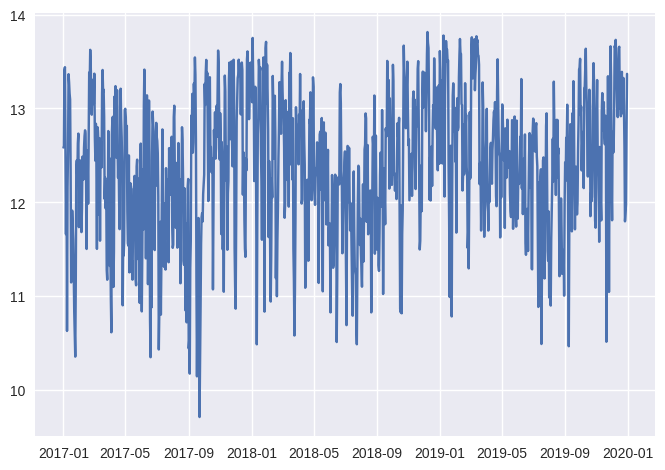

In [ ]:
plt.plot(log_data)

In [ ]:
adf_test = adfuller(log_data,autolag='AIC')
kpss_test = kpss(log_data, regression='c', nlags='auto', store=True)
kpss_test_trend = kpss(log_data, regression='ct', nlags='auto', store=True)
print('ADF p-value: ', adf_test[1])
print('KPSS p-value: ', kpss_test[1])
print('KPSS_trend p-value: ', kpss_test_trend[1])

ADF p-value:  3.653556594812611e-20
KPSS p-value:  0.029853478155177526
KPSS_trend p-value:  0.09774201242648742


In [ ]:
#level is not stationary, so differencing

Text(0.5, 0.98, 'ACF-PACF for wind generation')

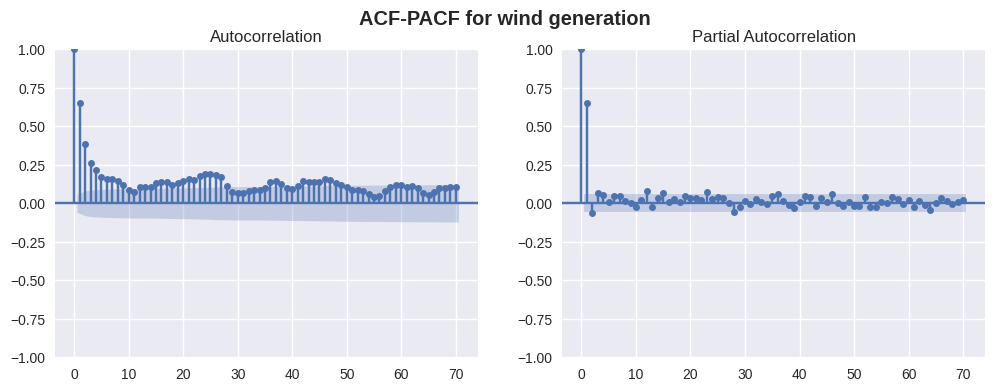

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
plot_acf(log_data, lags=70, ax=ax[0])
plot_pacf(log_data, lags=70, ax=ax[1])
plt.suptitle('ACF-PACF for wind generation', weight='bold')

In [79]:
diff_data = log_data.diff().dropna()

Text(0.5, 0.98, 'ACF-PACF for wind generation')

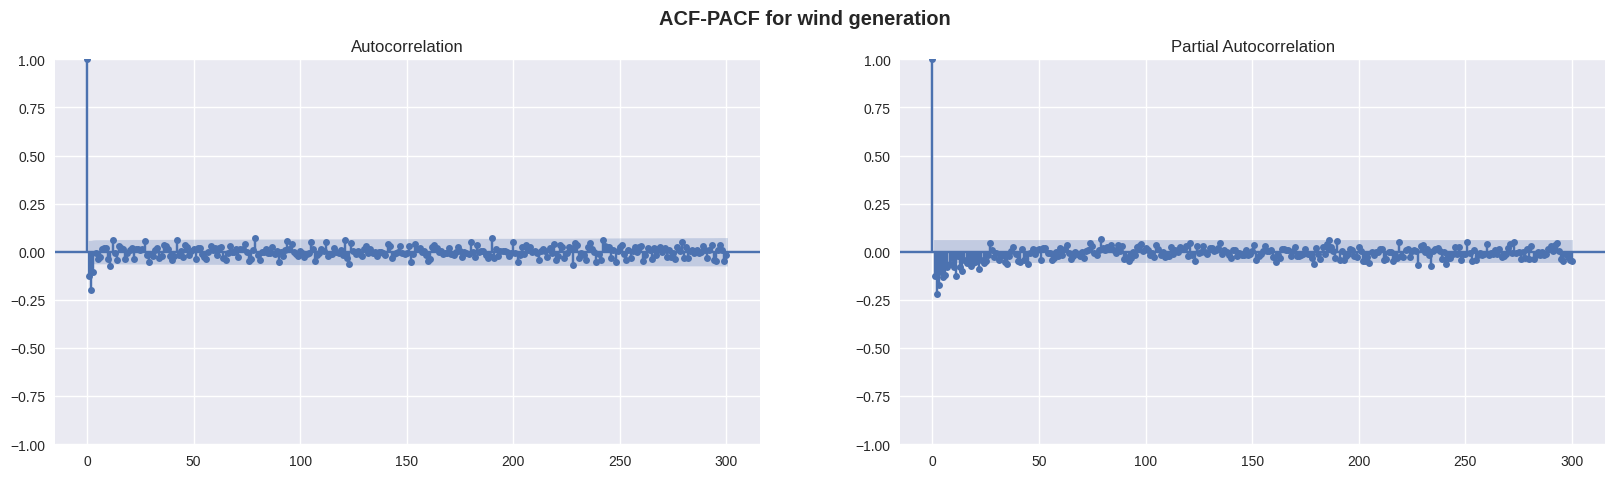

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(diff_data, lags=300, ax=ax[0])
plot_pacf(diff_data, lags=300, ax=ax[1])
plt.suptitle('ACF-PACF for wind generation', weight='bold')

In [ ]:
adf_test = adfuller(diff_data,autolag='AIC')
kpss_test = kpss(diff_data, regression='c', nlags='auto', store=True)
kpss_test_trend = kpss(diff_data, regression='ct', nlags='auto', store=True)
print('ADF p-value: ', adf_test[1])
print('KPSS p-value: ', kpss_test[1])
print('KPSS_trend p-value: ', kpss_test_trend[1])

ADF p-value:  3.5062490269931014e-23
KPSS p-value:  0.1
KPSS_trend p-value:  0.1


<ipython-input-151-5b32218aad6f>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(diff_data, regression='c', nlags='auto', store=True)
<ipython-input-151-5b32218aad6f>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_trend = kpss(diff_data, regression='ct', nlags='auto', store=True)


# **ETS on log data**

In [80]:
train_diff_log = diff_data.loc[:'2019-11-30']
test_diff_log = diff_data.loc['2019-12-01':]

In [ ]:
model_ETS_diff_log = ETSModel(train_diff_log['wind_generation_actual'], error = 'add', trend='add', damped_trend=False, seasonal='add',seasonal_periods=365).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Param Name    Values
0         smoothing_level  0.001565
1         smoothing_trend  0.000003
2      smoothing_seasonal  0.416058
3           initial_level -0.000644
4           initial_trend -0.000057
..                    ...       ...
365  initial_seasonal.360  0.299850
366  initial_seasonal.361  0.196200
367  initial_seasonal.362  0.267255
368  initial_seasonal.363  0.058338
369  initial_seasonal.364  0.000000

[370 rows x 2 columns]

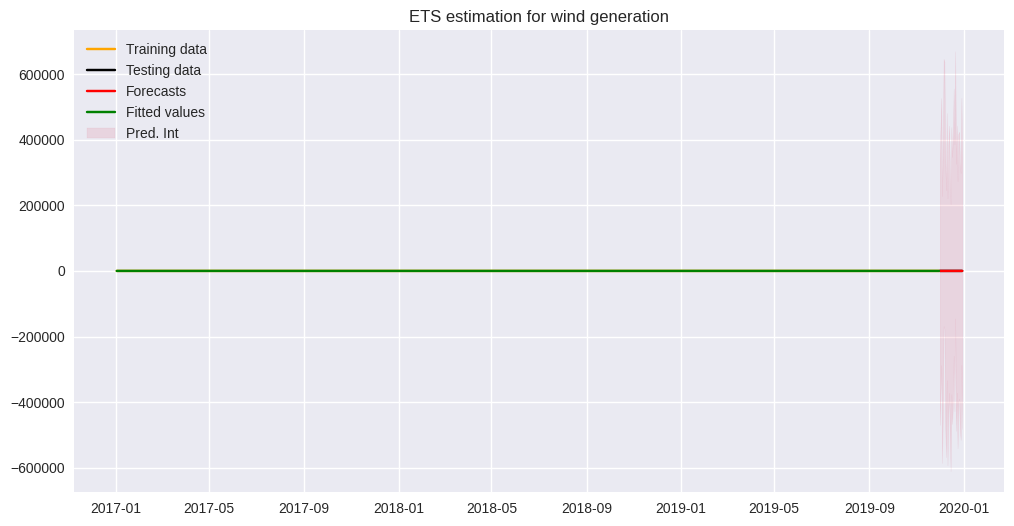

In [ ]:
pred_ETS_diff_log = model_ETS_diff_log.get_prediction(start=test.index[0], end=test.index[-1])
df_ETS_diff_log = pred_ETS_diff_log.summary_frame()
predictions_diff_log = df_ETS_diff_log['mean']

parameters_df = {'Param Name': model_ETS_diff_log.param_names, 'Values': model_ETS_diff_log.params}
parameters_df = pd.DataFrame(parameters_df)
display(parameters_df)

fig = plt.figure(figsize=(12,6))
plt.plot(train_diff_log['wind_generation_actual'], color='orange',label='Training data')
plt.plot(test_diff_log['wind_generation_actual'], color='black', label='Testing data')
plt.plot(predictions_diff_log, color='red', label='Forecasts')
plt.plot(model_ETS_diff_log.fittedvalues,color='green', label='Fitted values')
plt.fill_between(df_ETS_diff.index, df_ETS_diff['pi_lower'], df_ETS_diff['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.title('ETS estimation for wind generation')
plt.legend(loc='upper left');

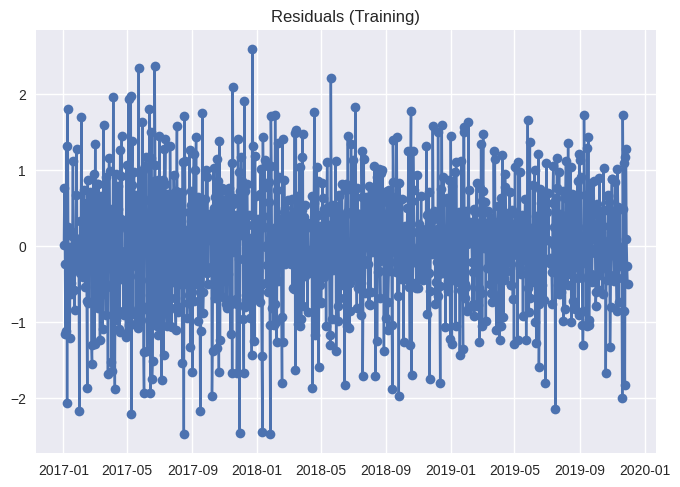

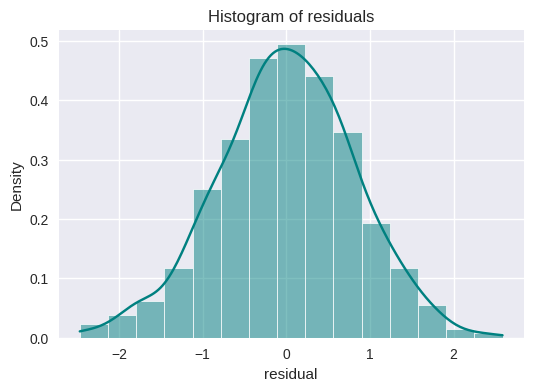

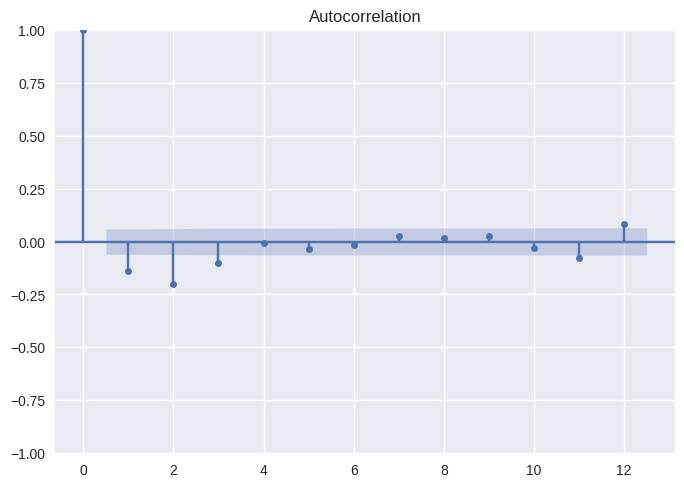

In [ ]:
plt.plot(model_ETS_diff_log.resid,'o-b');
plt.title('Residuals (Training)')


fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(x=model_ETS_diff_log.resid, stat='density', linewidth=0.5, kde=True,color='teal',bins=15)
ax.set(title='Histogram of residuals', xlabel='residual');


plot_acf(model_ETS_diff_log.resid,lags=12);